In [4]:
import pandas as pd
import numpy as np
from scipy.stats import stats
import os
import matplotlib.pyplot as plt
from random import choices
import xgboost as xgb
import xgboost as XGBClassifier

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score

import sys
sys.path.append('../src/')
import matrix_convert as mc


In [5]:
def Filter_low_Expr(arr):
    total_len = len(arr)
    count = 0
    for i in arr:
        if i > 0:
            count = count + 1
    if count > 0.5*total_len: #If 
        return(True)
    else:
        return(False)
    
def formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg,dic_gene_map):
    array_list = []
    new_id_list = []
    print("House keeping genes:")
    for gene1 in selected_genes_id:

        for gene2 in sele_house_keeping_id:
            #print(gene2 + ":" + gene1)
            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    print("Regulators:")
    for gene1 in selected_genes_id:
        cur_sele = KG_reg.loc[KG_reg['Target_gene'] == gene1]
        cur_regulators = list(cur_sele.loc[cur_sele['Coef'] < 0]['Regulator'])
        if gene1+"_intercept_" in cur_regulators:
            cur_regulators.remove(gene1+"_intercept_")
        #cur_regulators.remove(gene1+"_RSS")
        cur_regulators_ids = []
        for gene2 in cur_regulators:
            gene2 = dic_gene_map[gene2]
            if gene2 in dic_gene_map and gene2 in input_data.index:
                #print(gene2 + ":" + gene1)
                
                #cur_regulators_ids.append(dic_gene_map[i])
                new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
                new_arr_bi = []
                for i in new_arr:
                    if i > 0:
                        new_arr_bi.append(1)
                    else:
                        new_arr_bi.append(0)
                array_list.append(new_arr_bi)
                new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    new_feature_df = pd.DataFrame(array_list)
    new_feature_df.columns = input_data.columns
    new_feature_df.index = new_id_list
    new_feature_df_t = new_feature_df.transpose()
    return(new_feature_df_t)


def train_test_split_gq(df_sele, binary_cutoff, test_size):
    from sklearn.model_selection import train_test_split
    df_neg = df_sele.loc[df_sele['ic50'] > binary_cutoff]
    df_train_1, df_test_1 = train_test_split(df_neg, test_size = test_size)
    df_pos = df_sele.loc[df_sele['ic50'] <= binary_cutoff]
    df_train_2, df_test_2 = train_test_split(df_pos, test_size = test_size)
    
    df_train = pd.concat([df_train_1,df_train_2])
    df_test = pd.concat([df_test_1, df_test_2])
    
    return(df_train, df_test)

def model_run_with_Independent_testSet(train_data,test_data, train_labels, test_labels, independent_labels, independent_features): #modified at 11:46 AM Feb 15
    #xgb_model = xgb.XGBClassifier(n_jobs=4)
    #clf = GridSearchCV(xgb_model, {'max_depth': [5],
    #                               'n_estimators': [100], 
    #                               'learning_rate': [ 0.1],
    #                               #'gamma':[1],
    #                               #'eta':[0.2,0.3,0.4],
    #                              # 'min_child_weight':[1,2],
    #                              # 'lambda':[1,2],
    #                              # 'subsample':[0.8]
    #                              }, verbose=1,cv=5, n_jobs=4) #5-fold cross validation

    #clf.fit(train_data, train_labels.values)
    #print(clf.best_score_) #Train data
    #para = (clf.best_params_)
    #print(clf.best_params_)

    xgb_model = xgb.XGBClassifier(n_jobs=4, 
                                  learning_rate = 0.05, 
                                  max_depth= 8, 
                                  n_estimators= 100)
    
    xgb_model.fit(train_data,train_labels.values)
    #predictions = xgb_model.predict(test_data)
    
    predictions_train = xgb_model.predict(train_data)


    predictions = xgb_model.predict(test_data)
    
    predictions_independent = xgb_model.predict(independent_features)
    

    #print(pd.DataFrame({"Meausred": list(test_labels), "Predict": predictions}))
    # Evaluate the accuracy of the XGBoost model in the training set (beatAML wave 1/2)
    accuracy_train = accuracy_score(train_labels, predictions_train)
    cm_train = confusion_matrix(  list(train_labels), predictions_train)
    tn_train = cm_train[0,0] #labled as negative and predicted as negative
    fp_train = cm_train[0,1] #labeld as negative and predicted as positive
    fn_train = cm_train[1,0] #labeld as positive, and predicted as negative
    tp_train = cm_train[1,1] #labeld as positive, and predicted as positive

    sensitivity_train = cm_train[1,1]/(cm_train[1,0] + cm_train[1,1]) # TP/(FN + TP)
    specificity_train = tn_train/(tn_train+fp_train)

    precision_train = cm_train[1,1]/(cm_train[0,1] + cm_train[1,1])
    recall_train = recall_score(train_labels, predictions_train)
    blanced_acc_train = (sensitivity_train + specificity_train) /2
    f1_train = f1_score(list(train_labels), predictions_train)


    # Evaluate the accuracy of the XGBoost model in the validation set (beatAML wave 1/2)
    accuracy = accuracy_score(test_labels, predictions)
    cm = confusion_matrix(  list(test_labels), predictions)
    tn = cm[0,0] #labled as negative and predicted as negative 
    fp = cm[0,1] #labeld as negative and predicted as positive
    fn = cm[1,0] #labeld as positive, and predicted as negative
    tp = cm[1,1] #labeld as positive, and predicted as positive
    
    sensitivity = cm[1,1]/(cm[1,0] + cm[1,1]) # TP/(FN + TP)
    specificity = tn/(tn+fp)
    
    precision = cm[1,1]/(cm[0,1] + cm[1,1])
    recall = recall_score(test_labels, predictions)
    blanced_acc = (sensitivity + specificity) /2 
    f1 = f1_score(list(test_labels), predictions)
    
    # Evaluate the accuracy of the XGBoost model in the testing set (beatAML wave 3/4)
    accuracy_independent = accuracy_score(independent_labels, predictions_independent)
    f1_independent = f1_score(independent_labels, predictions_independent)
    cm_independent = confusion_matrix(  list(independent_labels), predictions_independent)
    tn_independent = cm_independent[0,0] #labled as negative and predicted as negative 
    fp_independent = cm_independent[0,1] #labeld as negative and predicted as positive
    fn_independent = cm_independent[1,0] #labeld as positive, and predicted as negative
    tp_independent = cm_independent[1,1] #labeld as positive, and predicted as positive
    
    sensitivity_independent = cm_independent[1,1]/(cm_independent[1,0] + cm_independent[1,1]) # TP/(FN + TP)
    specificity_independent = tn_independent/(tn_independent+fp_independent)
    
    precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
    recall_independent = recall_score(independent_labels, predictions_independent)
    blanced_acc_independent = (sensitivity_independent + specificity_independent) /2 
    recall_independent = recall_score(independent_labels, predictions_independent)
    # F1 = 2 x [(Precision x Recall) / (Precision + Recall)]

    #print("F1_score: " + str(f1))
    #print("# F1: 2 x [(Precision x Recall) / (Precision + Recall)]")

    result_feature = pd.DataFrame({"Feature":list(test_data.columns), "IMP":xgb_model.feature_importances_})
    result_feature= result_feature.loc[result_feature['IMP']>0].sort_values(by = ['IMP'], ascending = False)

    #features = ((list(result_feature.loc[result_feature['IMP']>0.05].sort_values(by = ["IMP"], ascending = False)['Feature'])))

    result_summary = {}
    #result_summary['random_state'] = random_

    result_summary['train_accuracy'] = accuracy_train
    result_summary['train_precision'] = precision_train
    result_summary['train_sensitivity'] = sensitivity_train
    result_summary['train_F1_score'] = f1_train
    result_summary['train_specificity'] = specificity_train
    result_summary['train_balanced_acc'] = blanced_acc_train
    result_summary['train_recall'] = recall_train
    

    #result_summary['best_params'] = clf.best_params_
    result_summary['Accuracy'] = accuracy #1
    result_summary['Precision'] = precision #2
    result_summary['sensitivity'] = sensitivity #3
    result_summary['F1_score'] = f1 #4
    result_summary['specificity'] = specificity #5
    result_summary['balanced_acc'] = blanced_acc #6
    result_summary['recall'] = recall #7
    
    
    result_summary['precision_independent'] = precision_independent #1
    result_summary['sensitivity_independent'] = sensitivity_independent #2
    result_summary['specificity_independent'] = specificity_independent #3
    result_summary['blanced_acc_independent'] = blanced_acc_independent #4
    result_summary['ACC_independent'] = accuracy_independent #5
    result_summary['F1_score_independent'] = f1_independent #6
    result_summary['recall_independent'] = recall_independent #7
    
    result_summary['features'] = result_feature
    return(result_summary)


#### The BeatAML wave 1/2 dataset is from the Tyler 2018 paper, and the BeatAML wave 3/4 dataset is from the Cancer Cell 2022 paper. The gene expression values are in general similar, but not exactly the same according to the data processing steps.




In [6]:
#data_all_w12 = pd.read_csv("../Data/beatAML_wave12_feature_ic50_highExpr_Mar19_2024_w12.csv", index_col= "Unnamed: 0")

# Load all data for beat AML wave 1 to 4 from the 2022 paper
data_all_w14 = pd.read_csv("../Data/beatAML_wave14_feature_ic50_highExpr_Mar19_2024_w1_4.csv", index_col= "Unnamed: 0")
print("wave 1 to 4 data:")
print(data_all_w14.shape)
print(data_all_w14.columns[0:23]) # Feature set 1 is from column 0 to 23
print(data_all_w14.columns[23:41]) # Feature set 2 is from column 23 to 41
#print(data_all_w14.columns[41:19894]) # Feature set 3 is from column 41 to 19894
#print(data_all_w14.columns[19894:20215]) # Drug response data is from column 19894 to 20215

# Load all data from the beat AML wave 1 to 2 data from the 2018 paper
data_all_w12 = pd.read_csv("../Data/beatAML_wave12_feature_ic50_highExpr_Apr30_2024_w12.csv", index_col= "Unnamed: 0")
print("wave 1 to 2 data:")
print(data_all_w12.shape)
print(data_all_w12.columns[0:22])
print(data_all_w12.columns[22:40])
#print(data_all_w12.columns[40:17731])
#print(data_all_w12.columns[17731:17853])

wave 1 to 4 data:
(969, 20215)
Index(['FLT3', 'SRSF2', 'CEBPA', 'SF3B1', 'NPM1', 'KRAS', 'RUNX1', 'DNMT3A',
       'ASXL1', 'IDH2', 'PTPN11', 'JAK2', 'PDS5B', 'STAG2', 'IDH1', 'BCOR',
       'TET2', 'GATA2', 'U2AF1', 'EZH2', 'WT1', 'NRAS', 'TP53'],
      dtype='object')
Index(['DNMT3A:p.R882', 'ASXL1:p.G645-646', 'FLT3:p.835-839', 'IDH1:p.R132',
       'IDH2:p.R140', 'IDH2:p.R172', 'JAK2:p.V617', 'KIT:p.D816',
       'KRAS:p.G12/13', 'NPM1:p.W288-90', 'NRAS:p.G12/13', 'NRAS:p.Q61',
       'SF3B1:p.K700E', 'SF3B1:p.K666', 'SRSF2:p.94-95', 'U2AF1:p.S34',
       'U2AF1:p.156-157', 'ZNF687:p.R939Pfs*36:151262327'],
      dtype='object')
wave 1 to 2 data:
(783, 17853)
Index(['EZH2', 'DNMT3A', 'BCOR', 'SF3B1', 'TET2', 'KRAS', 'U2AF1', 'CEBPA',
       'NPM1', 'GATA2', 'PTPN11', 'IDH2', 'NRAS', 'ASXL1', 'RUNX1', 'JAK2',
       'FLT3', 'WT1', 'STAG2', 'TP53', 'IDH1', 'SRSF2'],
      dtype='object')
Index(['DNMT3A:p.R882', 'ASXL1:p.G645-646', 'FLT3:p.835-839', 'IDH1:p.R132',
       'IDH2:p.R140'

#### Theare are 672 samples from the Beat AML wave 1/2 and 297 samples from wave 3/4


In [7]:
w12_shared_samples = list(set(data_all_w12.index).intersection(set(data_all_w14.index)))
print(len(w12_shared_samples))

w34_samples = list(set(data_all_w14.index) - set(w12_shared_samples))
print(len(w34_samples))

672
297


In [8]:
#for i in range(0,2,1):
#    feature = data_all_w12.columns[i]

#    x = pd.concat([data_all_w12.loc[w12_shared_samples,[feature]], 
#            data_all_w14.loc[w12_shared_samples,[feature]]], axis=1)
#    x.columns = [feature+'_w12', feature+'_w14']
#    x = x.dropna()
#
#    plt.scatter(x[feature+'_w12'], x[feature+'_w14'])
#    plt.xlabel('wave 1/2')
#    plt.ylabel('wave 1/4')
#    plt.title(feature)
 #   plt.show()

In [9]:

# Load testing data from BeatAML wave 3 and 4
#BeatAML_wave_3_expr = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/rnaseq/beataml_waves1to4_allnorm.txt", sep = "\t") 
#BeatAML_wave_3_drugResponse = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/inhibitor/beataml_probit_curve_fits_v4_distr_nonproprietary.txt", sep = "\t")

# read xlsx file
#BeatAML_all_clinic = pd.read_excel("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/clinical/beataml_wv1to4_clinical_summary_01_22_2021.xlsx")


In [10]:
BeatAML_w12_samples = set(data_all_w12.index).intersection(set(data_all_w14.index))
print(len(BeatAML_w12_samples))


672


In [11]:
BeatAML_w34_samples = set(data_all_w14.index) - BeatAML_w12_samples
BeatAML_w12_samples = set(data_all_w14.index).intersection(BeatAML_w12_samples)



In [12]:
BeatAML_w12_data = data_all_w12.loc[list(BeatAML_w12_samples),:]  # This is important to make sure which dataset is used for beatAML wave 1/2
BeatAML_w34_data = data_all_w14.loc[list(BeatAML_w34_samples),:]

print(len(BeatAML_w12_samples))
print(len(BeatAML_w34_samples))

672
297


In [13]:
BeatAML_w12_data_set1 = BeatAML_w12_data.columns[0:22]
BeatAML_w12_data_set2 = BeatAML_w12_data.columns[22:40]
BeatAML_w12_data_set3 = BeatAML_w12_data.columns[40:40+17691]


BeatAML_w34_data_set1 = BeatAML_w34_data.columns[0:23]
BeatAML_w34_data_set2 = BeatAML_w34_data.columns[23:41]
BeatAML_w34_data_set3 = BeatAML_w34_data.columns[41:41+19853]

featureset_1 = list(set(BeatAML_w12_data_set1).intersection(set(BeatAML_w34_data_set1)))
featureset_2 = list(set(BeatAML_w12_data_set2).intersection(set(BeatAML_w34_data_set2)))
featureset_3 = list(set(BeatAML_w12_data_set3).intersection(set(BeatAML_w34_data_set3)))

print([len(featureset_1), len(featureset_2), len(featureset_3)])

print(featureset_1)
print(featureset_2)
#print(featureset_3)

[22, 18, 17685]
['NPM1', 'IDH1', 'FLT3', 'CEBPA', 'ASXL1', 'STAG2', 'WT1', 'U2AF1', 'EZH2', 'JAK2', 'GATA2', 'SRSF2', 'IDH2', 'BCOR', 'TET2', 'SF3B1', 'NRAS', 'DNMT3A', 'TP53', 'PTPN11', 'RUNX1', 'KRAS']
['SRSF2:p.94-95', 'SF3B1:p.K700E', 'IDH2:p.R172', 'U2AF1:p.S34', 'DNMT3A:p.R882', 'JAK2:p.V617', 'IDH1:p.R132', 'KIT:p.D816', 'SF3B1:p.K666', 'FLT3:p.835-839', 'KRAS:p.G12/13', 'NRAS:p.G12/13', 'IDH2:p.R140', 'U2AF1:p.156-157', 'NRAS:p.Q61', 'ZNF687:p.R939Pfs*36:151262327', 'NPM1:p.W288-90', 'ASXL1:p.G645-646']


In [14]:
BeatAML_w12_data_set3_df = BeatAML_w12_data[featureset_3]
BeatAML_w12_data_set3_df_t = BeatAML_w12_data_set3_df.transpose()
print(BeatAML_w12_data_set3_df_t.shape)
BeatAML_w12_data_set3_df_t.head(4)

(17685, 672)


,12-00426,14-00712,13-00273,12-00069,16-00820,16-00249,13-00409,16-00566,15-00470,14-00720,...,15-00655,15-00626,15-00764,13-00147,16-00519,13-00454,16-00406,12-00051,15-00534,14-00067
ENSG00000198478,-2.441459,1.259787,NaN,NaN,3.397258,2.577138,-0.989121,1.922086,0.247195,NaN,...,NaN,5.556167,NaN,3.841622,1.583106,2.914862,2.604603,0.871915,3.470618,NaN
ENSG00000244462,6.868865,6.108719,NaN,NaN,6.445186,6.041413,6.034300,6.539453,5.833926,NaN,...,NaN,6.732783,NaN,5.824868,6.458981,5.731382,6.424298,6.397831,6.068774,NaN
ENSG00000107447,0.237599,-0.245079,NaN,NaN,5.596167,4.038601,0.537374,-0.620513,-1.232077,NaN,...,NaN,0.442742,NaN,6.666775,1.268084,3.572161,8.682019,0.508293,-1.633138,NaN
ENSG00000132749,5.077321,5.429578,NaN,NaN,3.091270,4.565115,3.640466,3.026411,4.083213,NaN,...,NaN,4.132178,NaN,4.108376,4.759418,0.768462,4.710982,3.178577,4.966797,NaN


In [15]:
BeatAML_w34_data_set3_df = BeatAML_w34_data[featureset_3]
BeatAML_w34_data_set3_df_t = BeatAML_w34_data_set3_df.transpose()
print(BeatAML_w34_data_set3_df_t.shape)
BeatAML_w34_data_set3_df_t.head(4)


(17685, 297)


,17-00055,19-00029,17-00337,18-00341,18-00101,17-00036,16-01245,19-00465,18-00110,18-00105,...,17-00867,18-00280,17-00915,13-00138,17-00883,17-00113,18-00029,13-00059,18-00073,17-00037
ENSG00000198478,4.088199,-0.167072,4.221639,1.272250,2.603533,4.006067,NaN,NaN,NaN,3.284706,...,1.610859,5.328312,3.588655,2.918630,4.178997,4.236615,0.472555,NaN,4.009887,4.541722
ENSG00000244462,7.121782,6.925414,6.292073,6.894283,7.063153,8.134386,NaN,NaN,NaN,7.213364,...,7.260518,7.012207,6.746311,7.335944,6.222444,7.556988,6.808793,NaN,6.635953,7.823934
ENSG00000107447,7.781256,-2.458695,3.019060,-2.099035,-1.911288,5.777750,NaN,NaN,NaN,2.755421,...,12.533339,4.480337,2.103786,7.241220,8.592224,6.783667,0.194504,NaN,2.803607,5.498135
ENSG00000132749,4.509443,3.150796,5.513434,4.966130,5.825764,4.840512,NaN,NaN,NaN,5.933169,...,4.919908,5.919586,4.957351,5.153967,5.632461,6.407079,3.340484,NaN,5.364816,4.285612


In [16]:
Data_dir = "/Users/guangrong/Documents/GitHub_project/AML_BeatAML/project/Data_resource/"
GE = pd.read_csv(Data_dir + "RPKM.csv",index_col = "Unnamed: 0")

#Formating gene expression data for training data
GE.index = GE['Gene']

# Define gene_map
gene_map = GE.loc[:,['Gene','Symbol']]
dic_gene_map = {}
for i in range(0,gene_map.shape[0]):
    dic_gene_map[gene_map.iloc[i,0]] = gene_map.iloc[i,1]
    dic_gene_map[gene_map.iloc[i,1]] = gene_map.iloc[i,0]

In [17]:
#Load features from features that predict drug response, regulatory graph and house keeping genes
#sele_house_keeping =  ["GPS2", "RPS10","ZNF91","FNTA","PSMC1","GPS1","MLH1","ARAF","SF3B2","PSMD2","SRP14","GNB1","HNRNPK","ARF1","RPS11"]
sele_house_keeping = ['RPS10','FNTA','COX6A1','BECN1', 'SF3B2','PSMB2','AUP1','SRP14','HNRNPK', 'CCNI', 'RHOA', 'PABPC1','RPS11','TPT1','FTL']
#KG_expr_resp = pd.read_csv("./Data/Supplementary_table_1_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")
KG_expr_resp = pd.read_csv("../Data/Supplementary_table_1_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")
#KG_reg = pd.read_csv("../Data/KG_regulatory_graph_Mar1_2023.csv")
KG_reg = pd.read_csv("../Data/KG_regulatory_graph_Mar11_2024.csv")


In [18]:
# Feature selection: Selection of first neighbors
#Drug = "JQ1"
Drug = "Trametinib (GSK1120212)"
#Drug = "Selumetinib (AZD6244)"
#Drug = "Venetoclax"
#Drug = "Vandetanib (ZD6474)"
#Drug = "Idelalisib"


res1 = KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]
res1 = res1.sort_values(by = ['coef'])
predictors = list(res1['Gene'])
predictors.remove(Drug+"_RSS")
predictors.remove(Drug+"_intercept")


# Selection of the second neighbors
res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors)]
res2 = res2.loc[res2['Coef'] <0]

selected_genes = list(KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]['Symbol'])
selected_genes.remove(Drug+"_RSS")
selected_genes.remove(Drug+"_intercept")



print(len(selected_genes))
print(selected_genes)



51
['AOC1', 'TBXAS1', 'RAB11FIP3', 'UQCC1', 'CA2', 'NDRG1', 'GLRX3', 'BLMH', 'CCND1', 'RALGPS2', 'RAB3GAP2', 'MED13L', 'FAM124B', 'SLC2A4RG', 'ARMCX1', 'ADCK2', 'GGACT', 'FHOD1', 'TNFRSF11A', 'ARHGAP18', 'LRRC3', 'SAFB', 'ZNF385A', 'SIGLEC16', 'ZNF75A', 'SLC22A15', 'NDRG2', 'TET2', 'GTSF1', 'ZNF274', 'GPHN', 'GATM', 'MYO1D', 'MROH1', 'LDOC1', 'PCBP3', 'FAM101B', 'CD300E', 'FAM221A', 'CTBP1-AS2', 'MT-CO2', 'LGR4', 'RP11-119F19.2', 'RPL41P1', 'AC079325.6', 'TPT1P9', 'DGUOK-AS1', 'CEBPA', 'RP11-317J10.2', 'RP11-439C15.4', 'U82695.10']


In [19]:
# Formating house keeping gene ids
sele_house_keeping_id = []
selected_genes_id = []

for g in selected_genes:
    selected_genes_id.append(dic_gene_map[g])
    
for g in sele_house_keeping:
    if g in dic_gene_map:
        sele_house_keeping_id.append(dic_gene_map[g])

In [20]:
# drop columns with missing values
training_data_beatAML_wave1_2 = BeatAML_w12_data_set3_df_t.dropna(axis=1)
test_data_beatAML_wave3_4 = BeatAML_w34_data_set3_df_t.dropna(axis=1)

In [21]:
new_feature_df_t = mc.formating_relative_expression(training_data_beatAML_wave1_2,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map= dic_gene_map)

new_feature_df_test = mc.formating_relative_expression(test_data_beatAML_wave3_4,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map= dic_gene_map)

House keeping genes:
Regulators:
House keeping genes:
Regulators:


In [22]:
print(new_feature_df_t.shape)
print(new_feature_df_test.shape)

(451, 1030)
(241, 1030)


In [23]:
# New added function to filter features 
# features for the relative gene expression data in Beat AML wave 1 and 2
print(new_feature_df_t.shape[0])

new_feature_df_t_filter_low = new_feature_df_t.loc[:,new_feature_df_t.sum(axis = 0) > 0.05*new_feature_df_t.shape[0]]
print(new_feature_df_t_filter_low.shape) # filter features with with more than 5% of the samples have non-zero values
new_feature_df_test_filter_high = new_feature_df_t_filter_low.loc[:,new_feature_df_t_filter_low.sum(axis = 0) < 0.95*new_feature_df_t.shape[0]]
print(new_feature_df_test_filter_high.shape) # filter features with with less than 95% of the samples have 1 values

new_feature_df_t = new_feature_df_test_filter_high  # Relative gene expression feature for wave 1 and 2

##df_sele = pd.concat([new_feature_df_t, Drug_sele_df],axis = 1)
#df_sele = df_sele.dropna()
##df_sele.head(3)
#df_sele.shape

# features for the relative gene expression data in Beat AML wave 3 and 4

new_feature_df_test = new_feature_df_test.loc[:,new_feature_df_t.columns] # Relative gene expression feature for wave 3 and 4

print(new_feature_df_test.shape)
print(new_feature_df_t.shape)

451
(451, 399)
(451, 301)
(241, 301)
(451, 301)


In [24]:
w12_f123 = BeatAML_w12_data.loc[:,featureset_1 + featureset_2 + featureset_3]
w12_drug = BeatAML_w12_data.loc[:,[Drug]]
df_sele_w12 = pd.concat([ w12_f123,new_feature_df_t,w12_drug],axis = 1)

w34_f123 = BeatAML_w34_data.loc[:,featureset_1 + featureset_2 + featureset_3]
w34_drug = BeatAML_w34_data.loc[:,[Drug]]
df_sele_w34 = pd.concat([ w34_f123,new_feature_df_test,w34_drug],axis = 1)

print(df_sele_w12.shape)
print(df_sele_w34.shape)



(672, 18027)
(297, 18027)


In [25]:
BeatAML_w12_data_set4 = list(new_feature_df_t.columns)
BeatAML_w34_data_set4 = list(new_feature_df_test.columns)
print(len(BeatAML_w34_data_set4))
print(len(BeatAML_w12_data_set4))

301
301


In [60]:
#set1 = list(df_sele_w34.columns[0:23])
#set2 = list(df_sele_w34.columns[23:40])
#set3 = list(df_sele_w34.columns[41:41+19853]) 
set4 = BeatAML_w34_data_set4
set1 = featureset_1 
set2 = featureset_2 
set3 = featureset_3

print(len(set1))
print(set1)
print(len(set2))
print(set2)
print(len(set3))
print(len(set4))
print(set4)

dic_dataset_test = {
    "Mut": df_sele_w34.loc[:,set1 + [Drug]].dropna(),
    "VAF": df_sele_w34.loc[:,set2+[Drug]].dropna(),
    "Mut+VAF": pd.concat([df_sele_w34[set1], df_sele_w34[set2], df_sele_w34[Drug]], axis = 1).dropna(),
    "Expr": pd.concat([df_sele_w34[featureset_3], df_sele_w34[Drug]], axis = 1).dropna(),
    "RelativeExpr": df_sele_w34.loc[:,set4 + [Drug]].dropna(),
    "Mut+VAF": pd.concat([df_sele_w34[set1], df_sele_w34[set2], df_sele_w34[Drug]], axis = 1).dropna(),
    "Mut+RelativeExpr": df_sele_w34[set1+ set4 + [Drug]].dropna(),
    "Mut+VAF+RelativeExpr": pd.concat([df_sele_w34[set1], df_sele_w34[set2], df_sele_w34[set4], df_sele_w34[Drug]], axis = 1),
}

dic_dataset_train = {
    "Mut": df_sele_w12.loc[:,set1 + [Drug]].dropna(),
    "VAF": df_sele_w12.loc[:,set2+[Drug]].dropna(),
    "Mut+VAF": pd.concat([df_sele_w12[set1], df_sele_w12[set2], df_sele_w12[Drug]], axis = 1).dropna(),
    "Expr": pd.concat([df_sele_w12[set3], df_sele_w12[Drug]], axis = 1).dropna(),
    "RelativeExpr": df_sele_w12.loc[:,set4 + [Drug]].dropna(),
    
    "Mut+RelativeExpr": df_sele_w12[set1+ set4 + [Drug]].dropna(),
    "Mut+VAF+RelativeExpr": pd.concat([df_sele_w12[set1], df_sele_w12[set2], df_sele_w12[set4], df_sele_w12[Drug]], axis = 1),
    }


22
['NPM1', 'IDH1', 'FLT3', 'CEBPA', 'ASXL1', 'STAG2', 'WT1', 'U2AF1', 'EZH2', 'JAK2', 'GATA2', 'SRSF2', 'IDH2', 'BCOR', 'TET2', 'SF3B1', 'NRAS', 'DNMT3A', 'TP53', 'PTPN11', 'RUNX1', 'KRAS']
18
['SRSF2:p.94-95', 'SF3B1:p.K700E', 'IDH2:p.R172', 'U2AF1:p.S34', 'DNMT3A:p.R882', 'JAK2:p.V617', 'IDH1:p.R132', 'KIT:p.D816', 'SF3B1:p.K666', 'FLT3:p.835-839', 'KRAS:p.G12/13', 'NRAS:p.G12/13', 'IDH2:p.R140', 'U2AF1:p.156-157', 'NRAS:p.Q61', 'ZNF687:p.R939Pfs*36:151262327', 'NPM1:p.W288-90', 'ASXL1:p.G645-646']
17685
301
['AOC1-RPS10', 'TBXAS1-FNTA', 'TBXAS1-COX6A1', 'TBXAS1-BECN1', 'TBXAS1-SF3B2', 'TBXAS1-PSMB2', 'RAB11FIP3-RPS10', 'RAB11FIP3-FNTA', 'RAB11FIP3-COX6A1', 'UQCC1-RPS10', 'UQCC1-FNTA', 'CA2-RPS10', 'CA2-FNTA', 'CA2-COX6A1', 'CA2-BECN1', 'CA2-SF3B2', 'CA2-PSMB2', 'CA2-AUP1', 'CA2-SRP14', 'NDRG1-COX6A1', 'NDRG1-BECN1', 'NDRG1-SF3B2', 'NDRG1-PSMB2', 'GLRX3-COX6A1', 'GLRX3-BECN1', 'BLMH-COX6A1', 'BLMH-BECN1', 'CCND1-RPS10', 'RALGPS2-RPS10', 'RALGPS2-FNTA', 'RALGPS2-COX6A1', 'RAB3GAP2-RP

In [61]:
dic_dataset_test["VAF"].sum(axis = 0).sort_values(ascending = False)

Trametinib (GSK1120212)          578.171359
NPM1:p.W288-90                    17.187946
SRSF2:p.94-95                     10.526745
IDH2:p.R140                       10.418096
DNMT3A:p.R882                      9.591541
NRAS:p.Q61                         5.850704
NRAS:p.G12/13                      5.698140
ASXL1:p.G645-646                   5.441226
FLT3:p.835-839                     4.542434
IDH1:p.R132                        4.357709
U2AF1:p.S34                        3.971377
KRAS:p.G12/13                      3.937080
SF3B1:p.K666                       2.328465
JAK2:p.V617                        1.877532
IDH2:p.R172                        1.789274
SF3B1:p.K700E                      1.435995
ZNF687:p.R939Pfs*36:151262327      0.707502
KIT:p.D816                         0.598090
U2AF1:p.156-157                    0.000000
dtype: float64

In [62]:

dic_dataset_train["VAF"].sum(axis = 0).sort_values(ascending = False)

Trametinib (GSK1120212)          1002.195047
NPM1:p.W288-90                     23.367252
SRSF2:p.94-95                      19.626245
DNMT3A:p.R882                      19.214876
IDH2:p.R140                        13.635234
NRAS:p.G12/13                      13.467443
IDH1:p.R132                        11.803490
FLT3:p.835-839                      8.787917
NRAS:p.Q61                          6.417871
JAK2:p.V617                         5.956488
SF3B1:p.K666                        4.437214
ASXL1:p.G645-646                    4.203919
KRAS:p.G12/13                       2.900662
KIT:p.D816                          2.882975
U2AF1:p.S34                         2.480581
U2AF1:p.156-157                     2.296425
SF3B1:p.K700E                       1.754863
IDH2:p.R172                         1.351577
ZNF687:p.R939Pfs*36:151262327       1.022639
dtype: float64

In [63]:

Data_dir = "/Users/guangrong/Documents/GitHub_project/AML_BeatAML/project/Data_resource/"
Drug_data = pd.read_csv(Data_dir + "Drug_Response.csv",index_col = "Unnamed: 0") 

# Formatting trainning data
Drug_sele_df = Drug_data.loc[Drug_data['inhibitor'] == Drug]
Drug_sele_df.index = Drug_sele_df['lab_id']
Drug_sele_df =Drug_sele_df.loc[:,['ic50']]

q25 =np.quantile(Drug_sele_df['ic50'].values, q = 0.25)
q50 = np.quantile(Drug_sele_df['ic50'].values, q = 0.5)
q75 = np.quantile(Drug_sele_df['ic50'].values, q = 0.75)

threshold_list_label = []
threshold_list = []
if q25 < 10:
    threshold_list.append(q25)
    threshold_list_label.append("Q25:" + str(round(q25,2)) + "μM")
if q50 < 10:
    threshold_list.append(q50)
    threshold_list_label.append("Q50:" + str(round(q50,2)) + "μM")
if q75 < 10:
    threshold_list.append(q75)
    threshold_list_label.append("Q75:" + str(round(q75,2)) + "μM")
#if q75 < 1:
#    threshold_list.append(1)

if max(threshold_list) < 1:
    threshold_list.append(1)
    threshold_list_label.append("1μM")
#if q75 < 1:
    
print(threshold_list)

[0.013717, 0.025725557096496952, 1]


In [64]:

result_with_threshod = {}
#threshold_list = [1]
for Threshod in threshold_list:
    result_with_threshod[Threshod] = {}

    for dataset in dic_dataset_train:

        print(dataset)
        data_cur_train = dic_dataset_train[dataset]
        data_cur_train = data_cur_train.dropna()
        new_label = []
        for i in list(data_cur_train[Drug].values):
            #print(i)
            if i <= Threshod:
                new_label.append(1)
            else:
                new_label.append(0)
        data_cur_train[Drug+"_bi"] = new_label

        data_cur_test = dic_dataset_test[dataset]
        data_cur_test = data_cur_test.dropna()
        new_label = []
        for i in list(data_cur_test[Drug].values):
            print("test!")
            print(i)
            if i <= Threshod:
                new_label.append(1)
                print(1)
            else:
                new_label.append(0)
                print(0)
        data_cur_test[Drug+"_bi"] = new_label

        result_all = {}
        result_all_test_w3 = {}

        sensitive_data = data_cur_train.loc[data_cur_train[Drug+"_bi"] == 1]
        resistant_data = data_cur_train.loc[data_cur_train[Drug+"_bi"] == 0]

        a = range(0,len(sensitive_data.index))
        
        k = int(len(sensitive_data.index)/10)
        a1 = choices(a, k = k)
        a2 = choices(list(set(a) - set(a1)), k = k)
        a3 = choices(list(set(a) - set(a1) - set(a2)), k = k)
        a4 = choices(list(set(a) - set(a1) - set(a2) - set(a3)), k = k)
        a5 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4)), k = k)
        a6 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5)), k = k)
        a7 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5) - set(a6)), k = k)
        a8 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5) - set(a6) - set(a7)), k = k)
        a9 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5) - set(a6) - set(a7) - set(a8)), k = k)
        a10 = list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5) - set(a6) - set(a7) - set(a8) - set(a9))


        b = range(0,len(resistant_data.index))
        k = int(len(resistant_data.index)/10)
        b1 = choices(b, k = k)
        b2 = choices(list(set(b) - set(b1)), k = k)
        b3 = choices(list(set(b) - set(b1) - set(b2)), k = k)
        b4 = choices(list(set(b) - set(b1) - set(b2) - set(b3)), k = k)
        b5 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4)), k = k)
        b6 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5)), k = k)
        b7 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5) - set(b6)), k = k)
        b8 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5) - set(b6) - set(b7)), k = k)
        b9 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5) - set(b6) - set(b7) - set(b8)), k = k)
        b10 = list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5) - set(b6) - set(b7) - set(b8) - set(b9))

        dic_fold = {
            1: [a1,b1],
            2: [a2,b2],
            3: [a3,b3],
            4: [a4,b4],
            5: [a5,b5],
            6: [a6,b6],
            7: [a7,b7],
            8: [a8,b8],
            9: [a9,b9],
            10: [a10,b10]
        }

        for fold in dic_fold:
            print(fold)
            test_train_sen = sensitive_data.iloc[dic_fold[fold][0],]
            test_train_res = resistant_data.iloc[dic_fold[fold][1],]
        
            train_data_sen = sensitive_data.iloc[list(set(a)-set(dic_fold[fold][0])),:]
            train_data_res = resistant_data.iloc[list(set(b)-set(dic_fold[fold][1])),:]

           
            train_data = pd.concat([train_data_sen.iloc[:,:-2], train_data_res.iloc[:,:-2]])
            test_data  = pd.concat([test_train_sen.iloc[:,:-2], test_train_res.iloc[:,:-2]])

            print(train_data.shape)
            print(test_data.shape)
            train_labels = pd.concat([train_data_sen.iloc[:,-1], train_data_res.iloc[:,-1]])
            test_labels = pd.concat([test_train_sen.iloc[:,-1], test_train_res.iloc[:,-1]])

            result_all[fold] = mc.model_run_with_Independent_testSet(train_data,
                                                                 test_data, 
                                                                 train_labels, 
                                                                 test_labels, 
                                                                 data_cur_test[Drug+"_bi"],  
                                                                 data_cur_test.iloc[:,:-2])
        
        
        result_with_threshod[Threshod][dataset] = result_all
    
    

Mut
test!
0.0137
1
test!
10.0
0
test!
0.0314956833437803
0
test!
0.297567663112668
0
test!
3.55499970168901
0
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
0.0197790410387978
0
test!
0.0137
1
test!
1.39001813306611
0
test!
0.0137
1
test!
10.0
0
test!
1.54669824434331
0
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.210887930332109
0
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
0.946747497067548
0
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.213440313897796
0
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
0.0353621261261795
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
7.93031550703609
0
test!
0.660150383882285
0
test!
0.138316077485239
0
test!
10.0
0
test!
1.1167593276

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_9024/4018516458.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_9024/4018516458.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


2
(233, 341)
(25, 341)
3
(233, 341)
(25, 341)
4
(233, 341)
(25, 341)
5
(234, 341)
(25, 341)
6
(234, 341)
(25, 341)
7
(234, 341)
(25, 341)
8
(235, 341)
(25, 341)
9
(234, 341)
(25, 341)
10
(209, 341)
(48, 341)
Mut
test!
0.0137
1
test!
10.0
0
test!
0.0314956833437803
0
test!
0.297567663112668
0
test!
3.55499970168901
0
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
0.0197790410387978
1
test!
0.0137
1
test!
1.39001813306611
0
test!
0.0137
1
test!
10.0
0
test!
1.54669824434331
0
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.210887930332109
0
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
0.946747497067548
0
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.213440313897796
0
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_9024/4018516458.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_9024/4018516458.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


2
(232, 341)
(25, 341)
3
(232, 341)
(25, 341)
4
(235, 341)
(25, 341)
5
(236, 341)
(25, 341)
6
(234, 341)
(25, 341)
7
(233, 341)
(25, 341)
8
(234, 341)
(25, 341)
9
(236, 341)
(25, 341)
10
(208, 341)
(49, 341)
Mut
test!
0.0137
1
test!
10.0
0
test!
0.0314956833437803
1
test!
0.297567663112668
1
test!
3.55499970168901
0
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
0.0197790410387978
1
test!
0.0137
1
test!
1.39001813306611
0
test!
0.0137
1
test!
10.0
0
test!
1.54669824434331
0
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.210887930332109
1
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
0.946747497067548
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.213440313897796
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137
1
test!
0.0137


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_9024/4018516458.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_9024/4018516458.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


2
(235, 341)
(25, 341)
3
(234, 341)
(25, 341)
4
(235, 341)
(25, 341)
5
(232, 341)
(25, 341)
6
(233, 341)
(25, 341)
7
(235, 341)
(25, 341)
8
(235, 341)
(25, 341)
9
(234, 341)
(25, 341)
10
(208, 341)
(49, 341)


In [80]:
Value_list = []
Type_list = []
Threshold_list = []

ACC_train_list = []
ACC_list = []
ACC_independent_test_list = []

F1_train_list = []
F1_list = []
F1_independent_test_list = []

feature_set_list = []
dataset_list    = []

for Threshod in  result_with_threshod:
    for feature_set in result_with_threshod[Threshod]:
        for random_state in result_with_threshod[Threshod][feature_set]:

            if "train_balanced_acc" in result_with_threshod[Threshod][feature_set][random_state]:
                ACC_train_list.append(result_with_threshod[Threshod][feature_set][random_state]['train_balanced_acc'])
                dataset_list.append("W1/2(Train)")
            if "balanced_acc" in result_with_threshod[Threshod][feature_set][random_state]:
                ACC_list.append(result_with_threshod[Threshod][feature_set][random_state]['balanced_acc'])
                dataset_list.append("W1/2(Validation)")
            if "blanced_acc_independent" in result_with_threshod[Threshod][feature_set][random_state]:
                dataset_list.append("W3/4(Test)")
                ACC_independent_test_list.append(result_with_threshod[Threshod][feature_set][random_state]['blanced_acc_independent'])
                
            if "train_F1_score" in result_with_threshod[Threshod][feature_set][random_state]:
                F1_train_list.append(result_with_threshod[Threshod][feature_set][random_state]['train_F1_score'])
                dataset_list.append("W1/2(Train)")
                
            if "F1_score" in result_with_threshod[Threshod][feature_set][random_state]:
                F1_list.append(result_with_threshod[Threshod][feature_set][random_state]['F1_score'])
            if "F1_score_independent" in result_with_threshod[Threshod][feature_set][random_state]:
                F1_independent_test_list.append(result_with_threshod[Threshod][feature_set][random_state]['F1_score_independent'])

            Threshold_list.append(Threshod)
            feature_set_list.append(feature_set)

In [81]:
result_with_threshod.keys()

dict_keys([0.013717, 0.025725557096496952, 1])

In [82]:
result_df = pd.DataFrame({"Threshold":Threshold_list + Threshold_list+Threshold_list, 
                          "Feature_set":feature_set_list + feature_set_list + feature_set_list,
                          "Balanced_ACC":ACC_train_list + ACC_list+ACC_independent_test_list, 
                          "F1":F1_train_list + F1_list + F1_independent_test_list,
                         "Dataset":['W1/2(Train)']* len(Threshold_list)+ ['W1/2(Validation)']*len(Threshold_list) +['W3/4(Test)']*len(Threshold_list) })
                        

In [83]:

for Feature_cur in set(result_df['Feature_set']):
    print("----------------------")
    print(Feature_cur)
    for threshold in result_with_threshod.keys():
        print("++++++++++++++++++++++++++++")
        print("threshold: " + str(threshold))
        x = result_df.loc[result_df['Feature_set'] == Feature_cur] 
        x = x.loc[x['Threshold'] == threshold]
        x = x.loc[x['Dataset'] == "W1/2(Train)"]

        print("W1/2(Train)")

        print("Balanced ACC: " + str(np.median(x['Balanced_ACC'])))
        print("Median F1 score: " + str(np.median(x['F1'])))

        x = result_df.loc[result_df['Feature_set'] == Feature_cur] 
        x = x.loc[x['Threshold'] == threshold]
        x = x.loc[x['Dataset'] == "W1/2(Validation)"]

        print("W1/2(Validation)")

        print("Balanced ACC: " + str(np.median(x['Balanced_ACC'])))
        print("Median F1 score: " + str(np.median(x['F1'])))



        print("Wave 3/4")
        x = result_df.loc[result_df['Feature_set'] == Feature_cur] 
        x = x.loc[x['Threshold'] == threshold]
        x = x.loc[x['Dataset'] == "W3/4(Test)"]

        print(x['Balanced_ACC'].values)
        print("Balanced ACC: " + str(np.median(x['Balanced_ACC'])))
        print("Median F1 score: " + str(np.median(x['F1'])))


----------------------
Mut+VAF+RelativeExpr
++++++++++++++++++++++++++++
threshold: 0.013717
W1/2(Train)
Balanced ACC: 1.0
Median F1 score: 1.0
W1/2(Validation)
Balanced ACC: 0.7103020892151326
Median F1 score: 0.6875
Wave 3/4
[0.69159664 0.70175707 0.73239114 0.7500382  0.69747899 0.74354469
 0.71168831 0.73582888 0.73300229 0.70458365]
Balanced ACC: 0.7220397249809014
Median F1 score: 0.6900000000000001
++++++++++++++++++++++++++++
threshold: 0.025725557096496952
W1/2(Train)
Balanced ACC: 1.0
Median F1 score: 1.0
W1/2(Validation)
Balanced ACC: 0.7163461538461539
Median F1 score: 0.681159420289855
Wave 3/4
[0.72281531 0.69871893 0.69810889 0.7104621  0.71709623 0.75987494
 0.66257435 0.71740125 0.72251029 0.66104926]
Balanced ACC: 0.7137791673021199
Median F1 score: 0.7066013696448479
++++++++++++++++++++++++++++
threshold: 1
W1/2(Train)
Balanced ACC: 1.0
Median F1 score: 1.0
W1/2(Validation)
Balanced ACC: 0.7795138888888888
Median F1 score: 0.8424317617866004
Wave 3/4
[0.69609164 0.7

In [84]:
result_df

,Threshold,Feature_set,Balanced_ACC,F1,Dataset
0,0.013717,Mut,0.741667,0.678733,W1/2(Train)
1,0.013717,Mut,0.726366,0.660714,W1/2(Train)
2,0.013717,Mut,0.724686,0.657658,W1/2(Train)
3,0.013717,Mut,0.709844,0.630137,W1/2(Train)
4,0.013717,Mut,0.737850,0.675556,W1/2(Train)
...,...,...,...,...,...
625,1.000000,Mut+VAF+RelativeExpr,0.717655,0.800000,W3/4(Test)
626,1.000000,Mut+VAF+RelativeExpr,0.705020,0.805556,W3/4(Test)
627,1.000000,Mut+VAF+RelativeExpr,0.678740,0.801802,W3/4(Test)
628,1.000000,Mut+VAF+RelativeExpr,0.726584,0.803828,W3/4(Test)


[Text(0, 0, '0.013717'), Text(1, 0, '0.025725557096496952'), Text(2, 0, '1.0')]


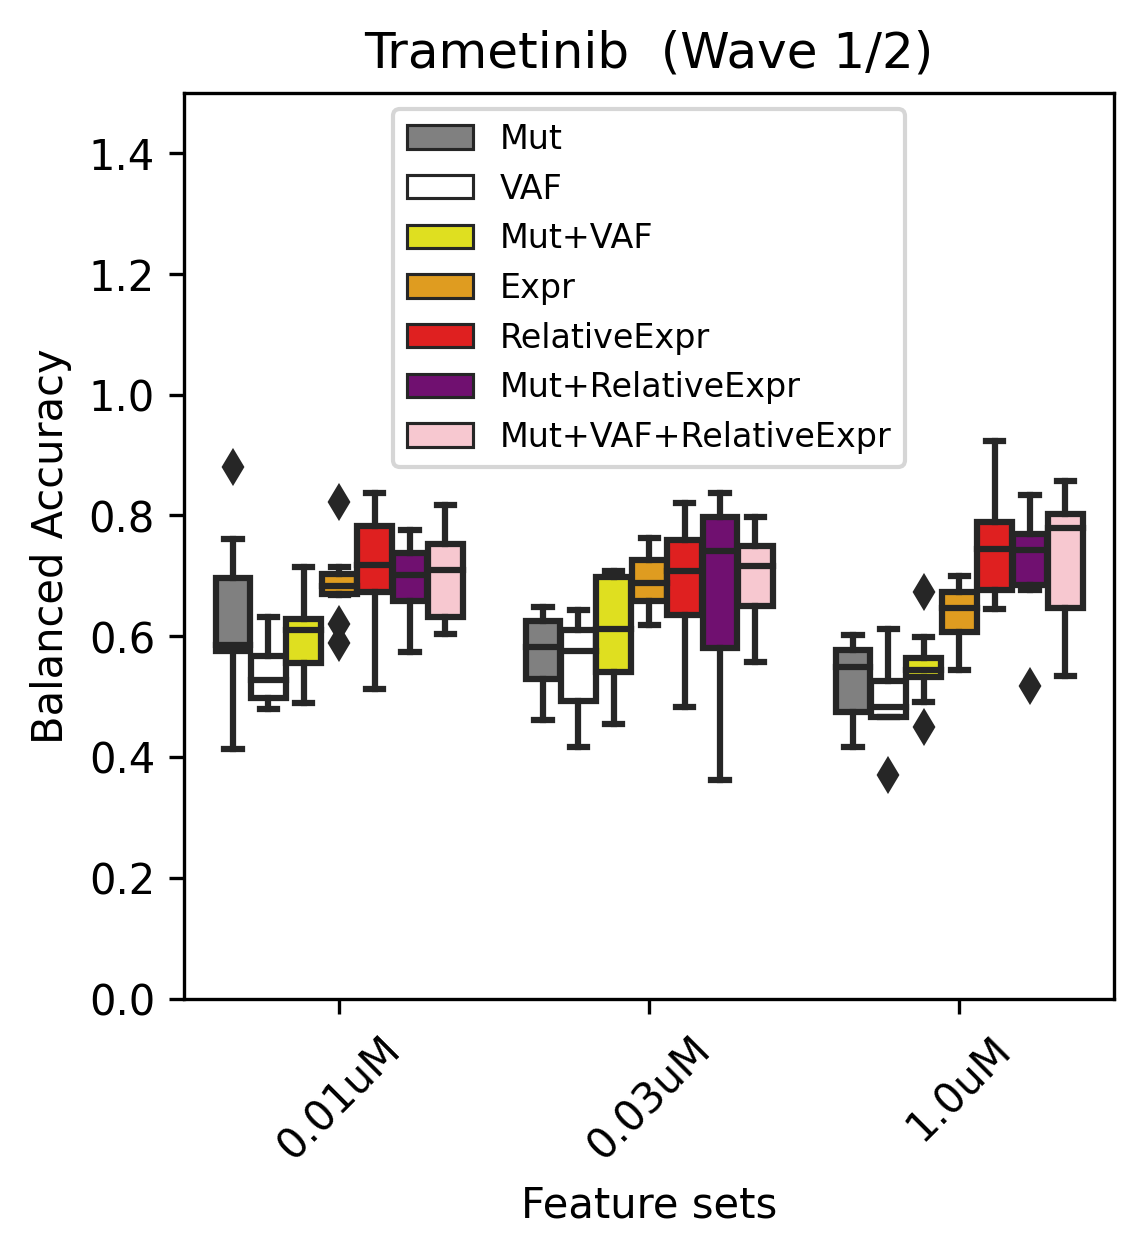

In [85]:
import seaborn as sns

result_df_cur_threshod = result_df.loc[result_df['Dataset'] =="W1/2(Validation)" ]

    #boxplot of result_df_cur_threshold grouped by feature_set
plt.figure(figsize = (4,4),dpi = 300)
sns.boxplot(x="Threshold", y="Balanced_ACC",
                hue="Feature_set", palette=["grey","white","yellow","orange" ,"red","purple","pink"],
                data=result_df_cur_threshod)
xticks_locs, xticks_labels = plt.xticks()
print(xticks_labels)
for i in range(0,len(xticks_labels)):
        xticks_labels[i] = str(round(float(xticks_labels[i].get_text()),2)) + "uM"

plt.xticks(xticks_locs, xticks_labels, rotation = 45)
plt.ylim(0,1.5)
plt.title(Drug.split("(")[0] +" (Wave 1/2)")
    #threshold_list_label = ["set1","set3","set4","set1&4"]
    #plt.xticks(range(0,len(threshold_list_label)), threshold_list_label, rotation = 90)
# set legend font size
plt.legend(fontsize = 8)
plt.ylabel("Balanced Accuracy")
plt.xlabel("Feature sets")


plt.show()




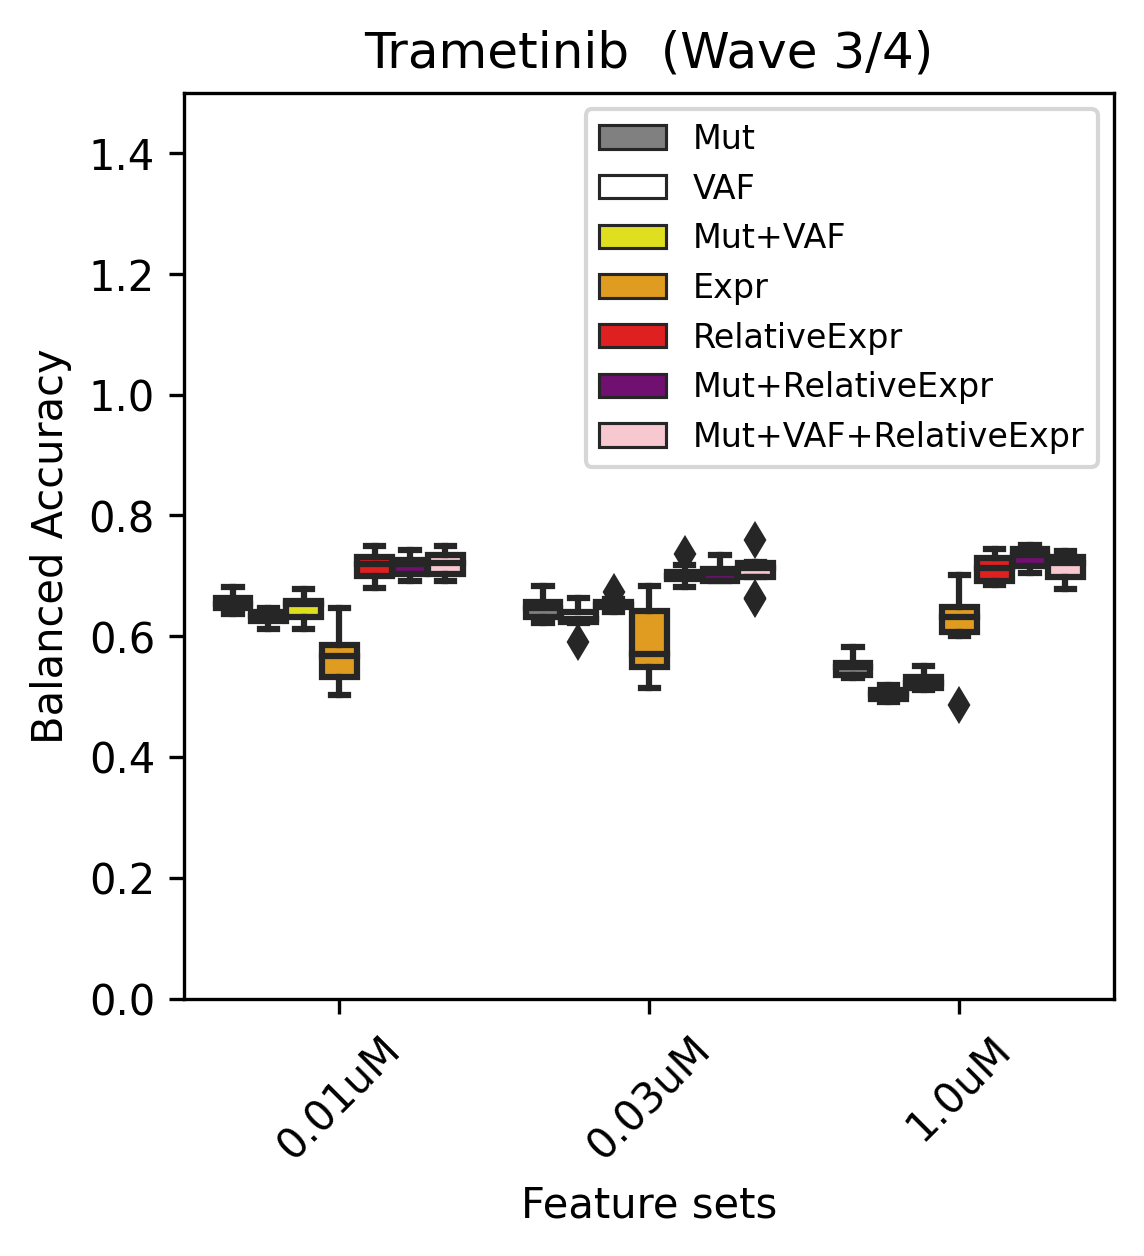

In [86]:

result_df_cur_threshod = result_df.loc[result_df['Dataset'] =="W3/4(Test)" ]

    #boxplot of result_df_cur_threshold grouped by feature_set
plt.figure(figsize = (4,4),dpi = 300)
sns.boxplot(x="Threshold", y="Balanced_ACC",
                hue="Feature_set", palette=["grey","white","yellow","orange" ,"red","purple","pink"],
                data=result_df_cur_threshod)
xticks_locs, xticks_labels = plt.xticks()
for i in range(0,len(xticks_labels)):
    xticks_labels[i] = str(round(float(xticks_labels[i].get_text()),2)) + "uM"

plt.xticks(xticks_locs, xticks_labels, rotation = 45)
plt.ylim(0,1.5)
plt.legend(fontsize = 8)
plt.title(Drug.split("(")[0]+" (Wave 3/4)" )
    #threshold_list_label = ["set1","set3","set4","set1&4"]

plt.ylabel("Balanced Accuracy")
plt.xlabel("Feature sets")
plt.show()

In [99]:
# get the median value for each group in the result_df_cur_threshod dataframe

result_df_cur_threshod.groupby(["Threshold","Feature_set"]).median()

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_9024/3277876921.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result_df_cur_threshod.groupby(["Threshold","Feature_set"]).median()


Balanced_ACC        F1
Threshold Feature_set                                 
1.0       Expr                      0.672799  0.774226
          Mut                       0.561923  0.736838
          Mut+RelativeExpr          0.750674  0.841674
          Mut+VAF                   0.551533  0.729578
          Mut+VAF+RelativeExpr      0.779514  0.842432
          RelativeExpr              0.756180  0.828210
          VAF                       0.511508  0.751238

[Text(0, 0, '0.013717'), Text(1, 0, '0.025725557096496952'), Text(2, 0, '1.0')]


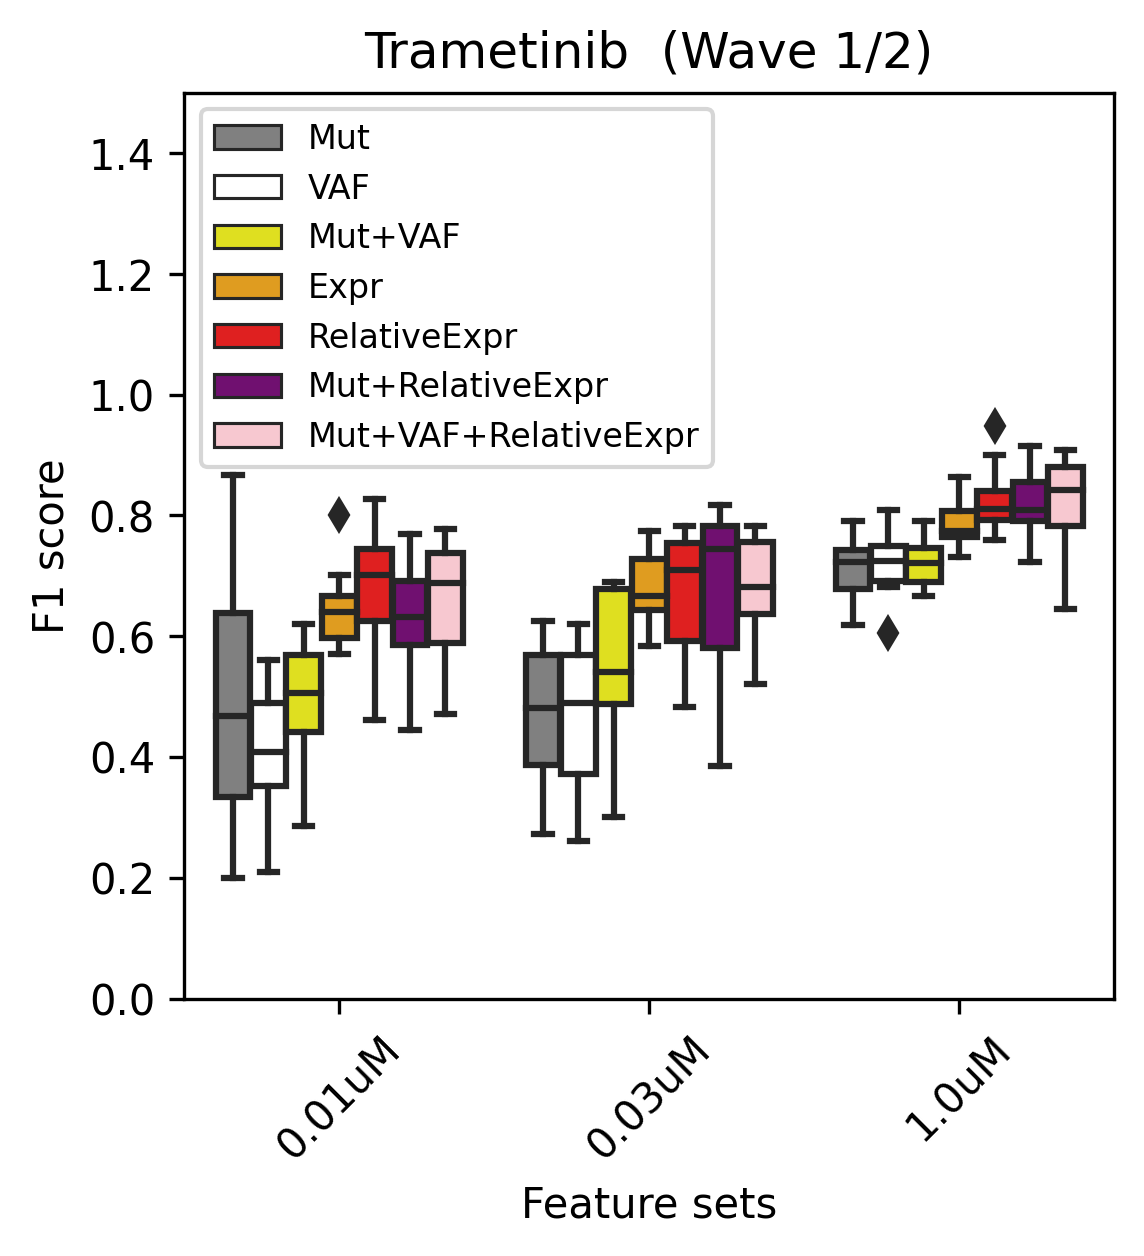

In [88]:
import seaborn as sns

result_df_cur_threshod = result_df.loc[result_df['Dataset'] =="W1/2(Validation)" ]

    #boxplot of result_df_cur_threshold grouped by feature_set
plt.figure(figsize = (4,4),dpi = 300)
sns.boxplot(x="Threshold", y="F1",
                hue="Feature_set", palette=["grey","white","yellow","orange" ,"red","purple","pink"],
                data=result_df_cur_threshod)
xticks_locs, xticks_labels = plt.xticks()
print(xticks_labels)
for i in range(0,len(xticks_labels)):
        xticks_labels[i] = str(round(float(xticks_labels[i].get_text()),2)) + "uM"

plt.xticks(xticks_locs, xticks_labels, rotation = 45)
plt.ylim(0,1.5)
plt.legend(fontsize = 8)
plt.title(Drug.split("(")[0] +" (Wave 1/2)")
    #threshold_list_label = ["set1","set3","set4","set1&4"]
    #plt.xticks(range(0,len(threshold_list_label)), threshold_list_label, rotation = 90)

plt.ylabel("F1 score")
plt.xlabel("Feature sets")
plt.show()




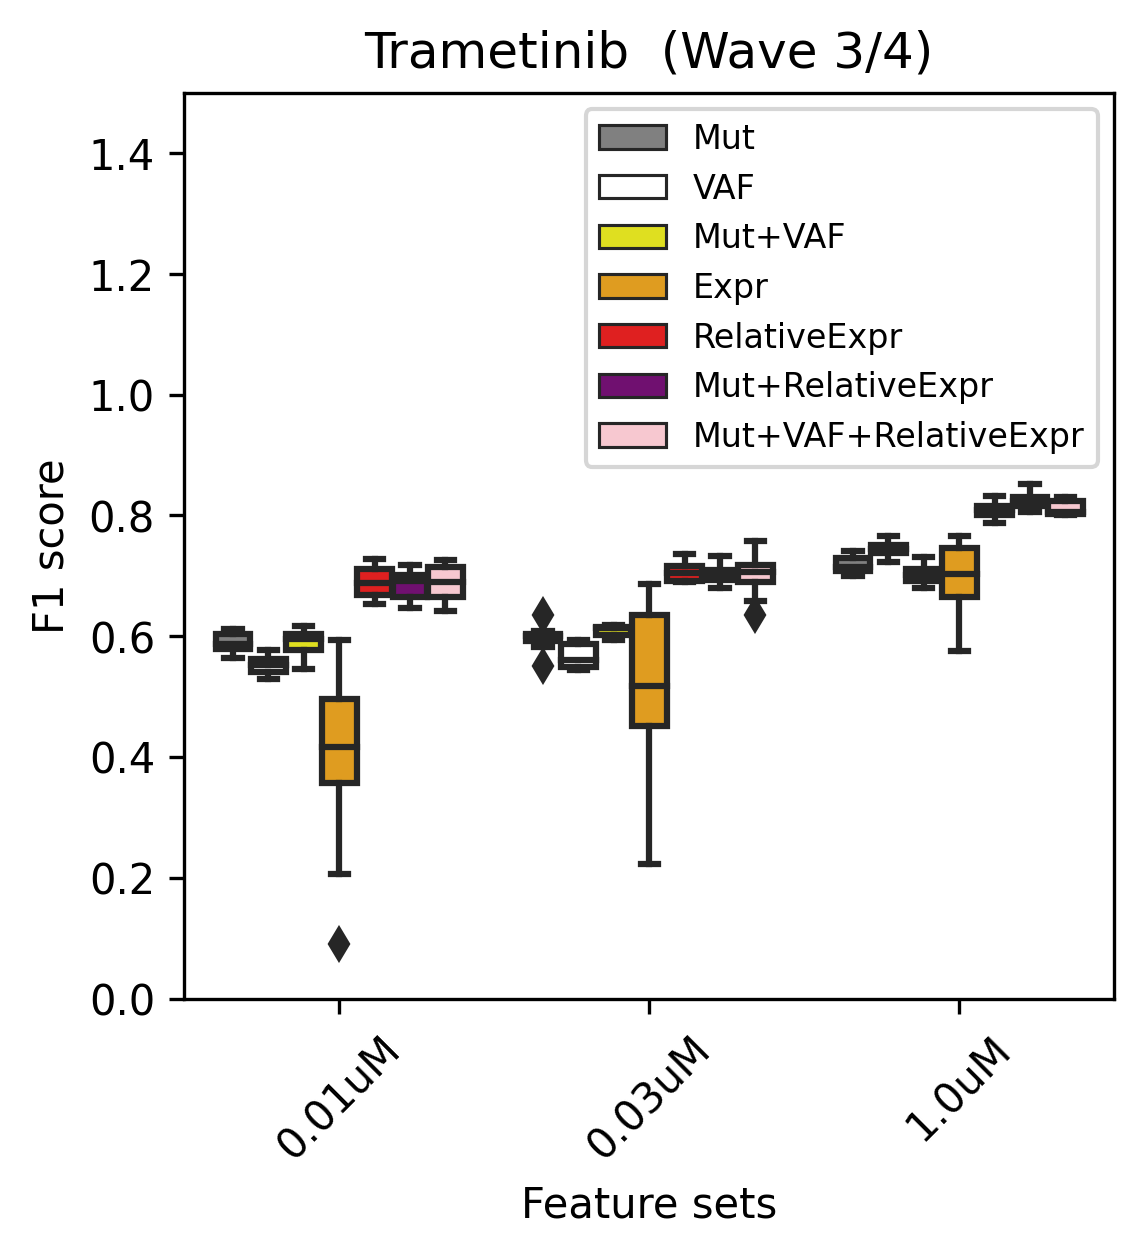

In [89]:

result_df_cur_threshod = result_df.loc[result_df['Dataset'] =="W3/4(Test)" ]

    #boxplot of result_df_cur_threshold grouped by feature_set
plt.figure(figsize = (4,4),dpi = 300)
sns.boxplot(x="Threshold", y="F1",
                hue="Feature_set", palette=["grey","white","yellow","orange" ,"red","purple","pink"],
                data=result_df_cur_threshod)
xticks_locs, xticks_labels = plt.xticks()
for i in range(0,len(xticks_labels)):
    xticks_labels[i] = str(round(float(xticks_labels[i].get_text()),2)) + "uM"

plt.xticks(xticks_locs, xticks_labels, rotation = 45)
plt.ylim(0,1.5)
plt.legend(fontsize = 8)
plt.title(Drug.split("(")[0]+" (Wave 3/4)" )
    #threshold_list_label = ["set1","set3","set4","set1&4"]
    
plt.ylabel("F1 score")
plt.xlabel("Feature sets")
plt.show()

In [90]:
result_df_cur_threshod.groupby(["Threshold","Feature_set"]).median()

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_9024/3367169410.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result_df_cur_threshod.groupby(["Threshold","Feature_set"]).median()


Balanced_ACC        F1
Threshold Feature_set                                 
0.013717  Expr                      0.567554  0.415942
          Mut                       0.652795  0.587879
          Mut+RelativeExpr          0.719404  0.692050
          Mut+VAF                   0.653004  0.595750
          Mut+VAF+RelativeExpr      0.722040  0.690000
          RelativeExpr              0.719864  0.688620
          VAF                       0.633552  0.552616
0.025726  Expr                      0.570385  0.517849
          Mut                       0.646587  0.600000
          Mut+RelativeExpr          0.704591  0.699716
          Mut+VAF                   0.651225  0.614081
          Mut+VAF+RelativeExpr      0.713779  0.706601
          RelativeExpr              0.700388  0.704860
          VAF                       0.628035  0.560315
1.000000  Expr                      0.632197  0.703283
          Mut                       0.548413  0.715076
          Mut+RelativeExpr          0.734164  0.824087
          Mut+VAF                   0.522222  0.700913
          Mut+VAF+RelativeExpr      0.722119  0.805493
          RelativeExpr              0.713636  0.808874
          VAF                       0.504762  0.743737

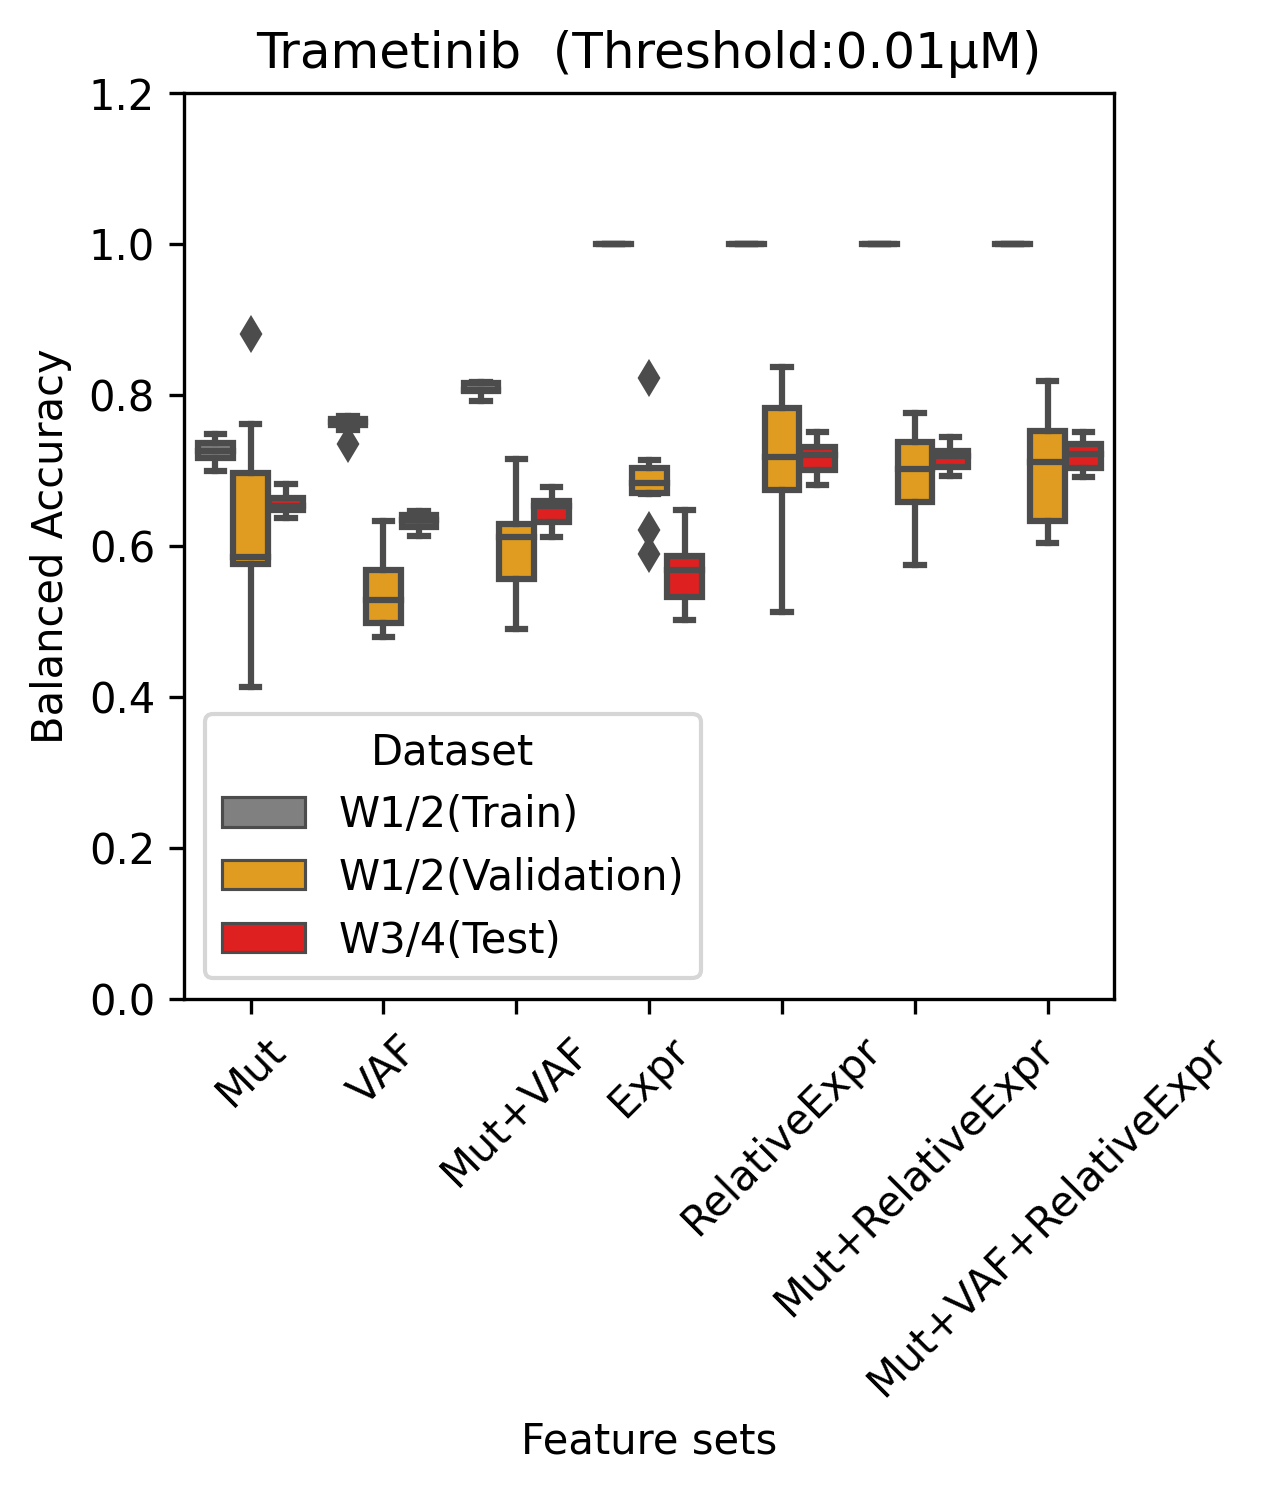

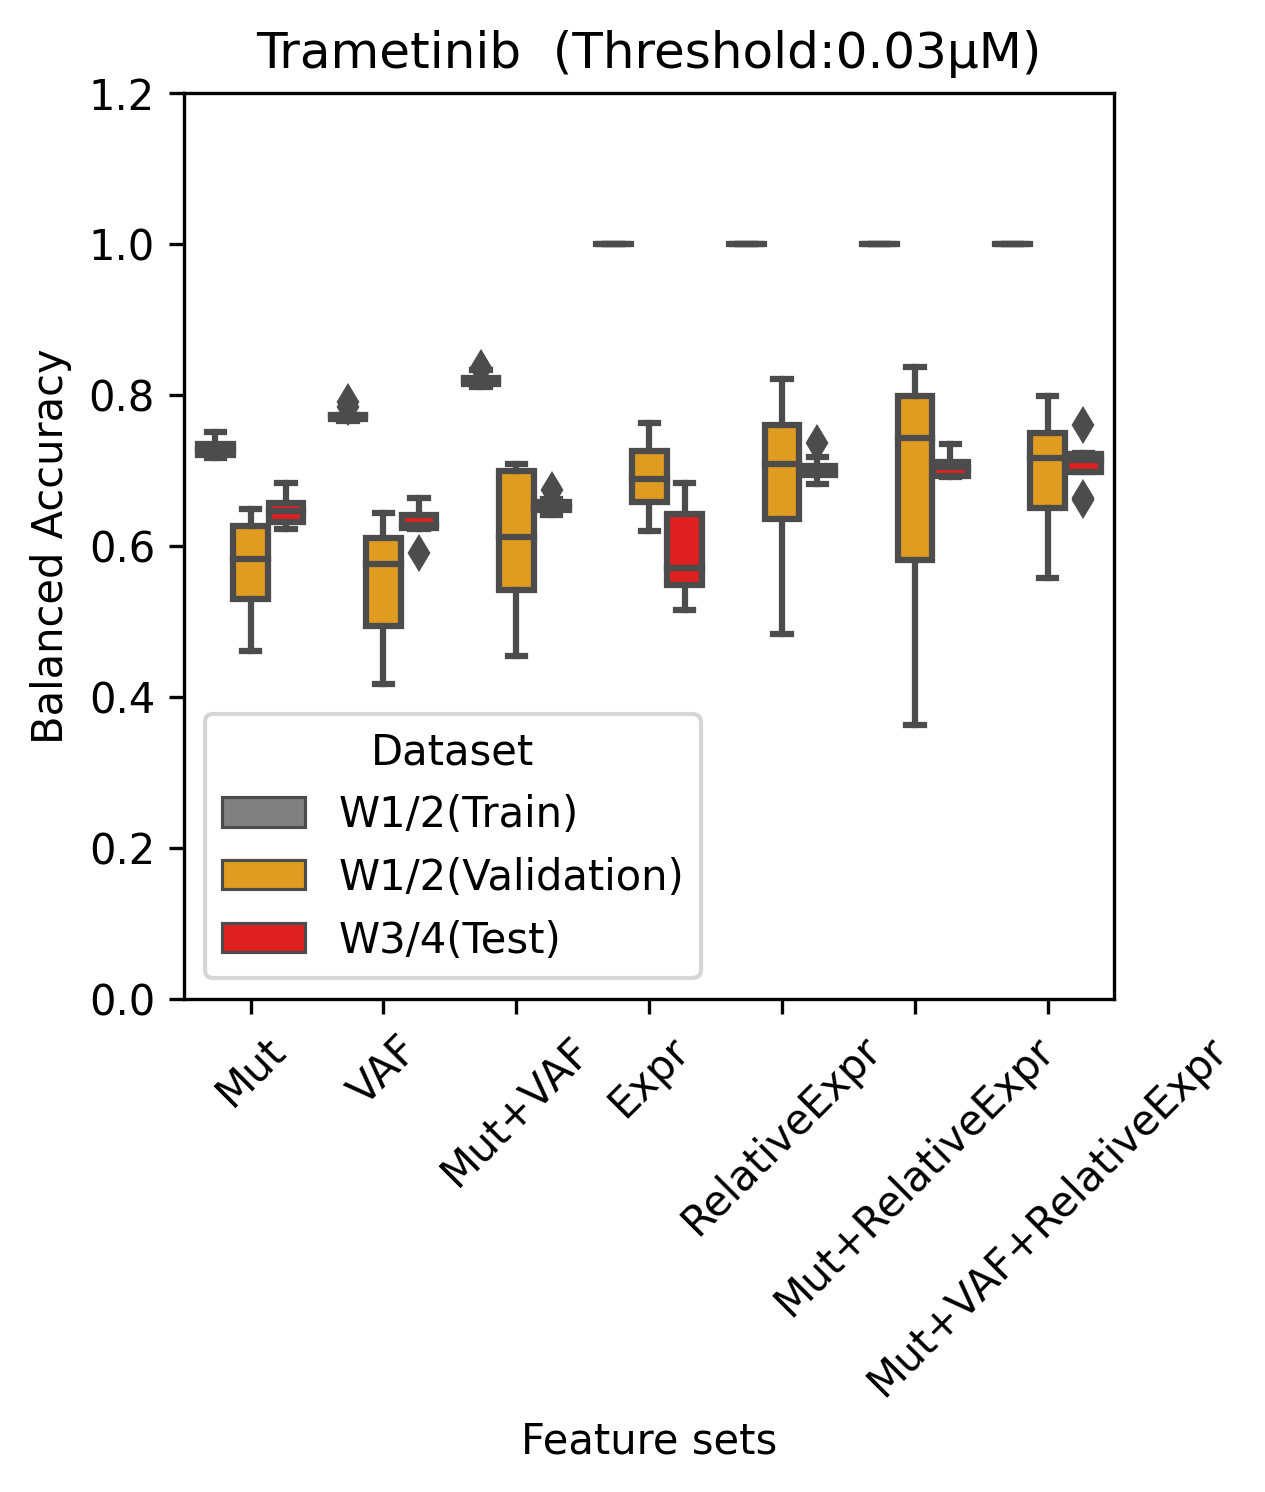

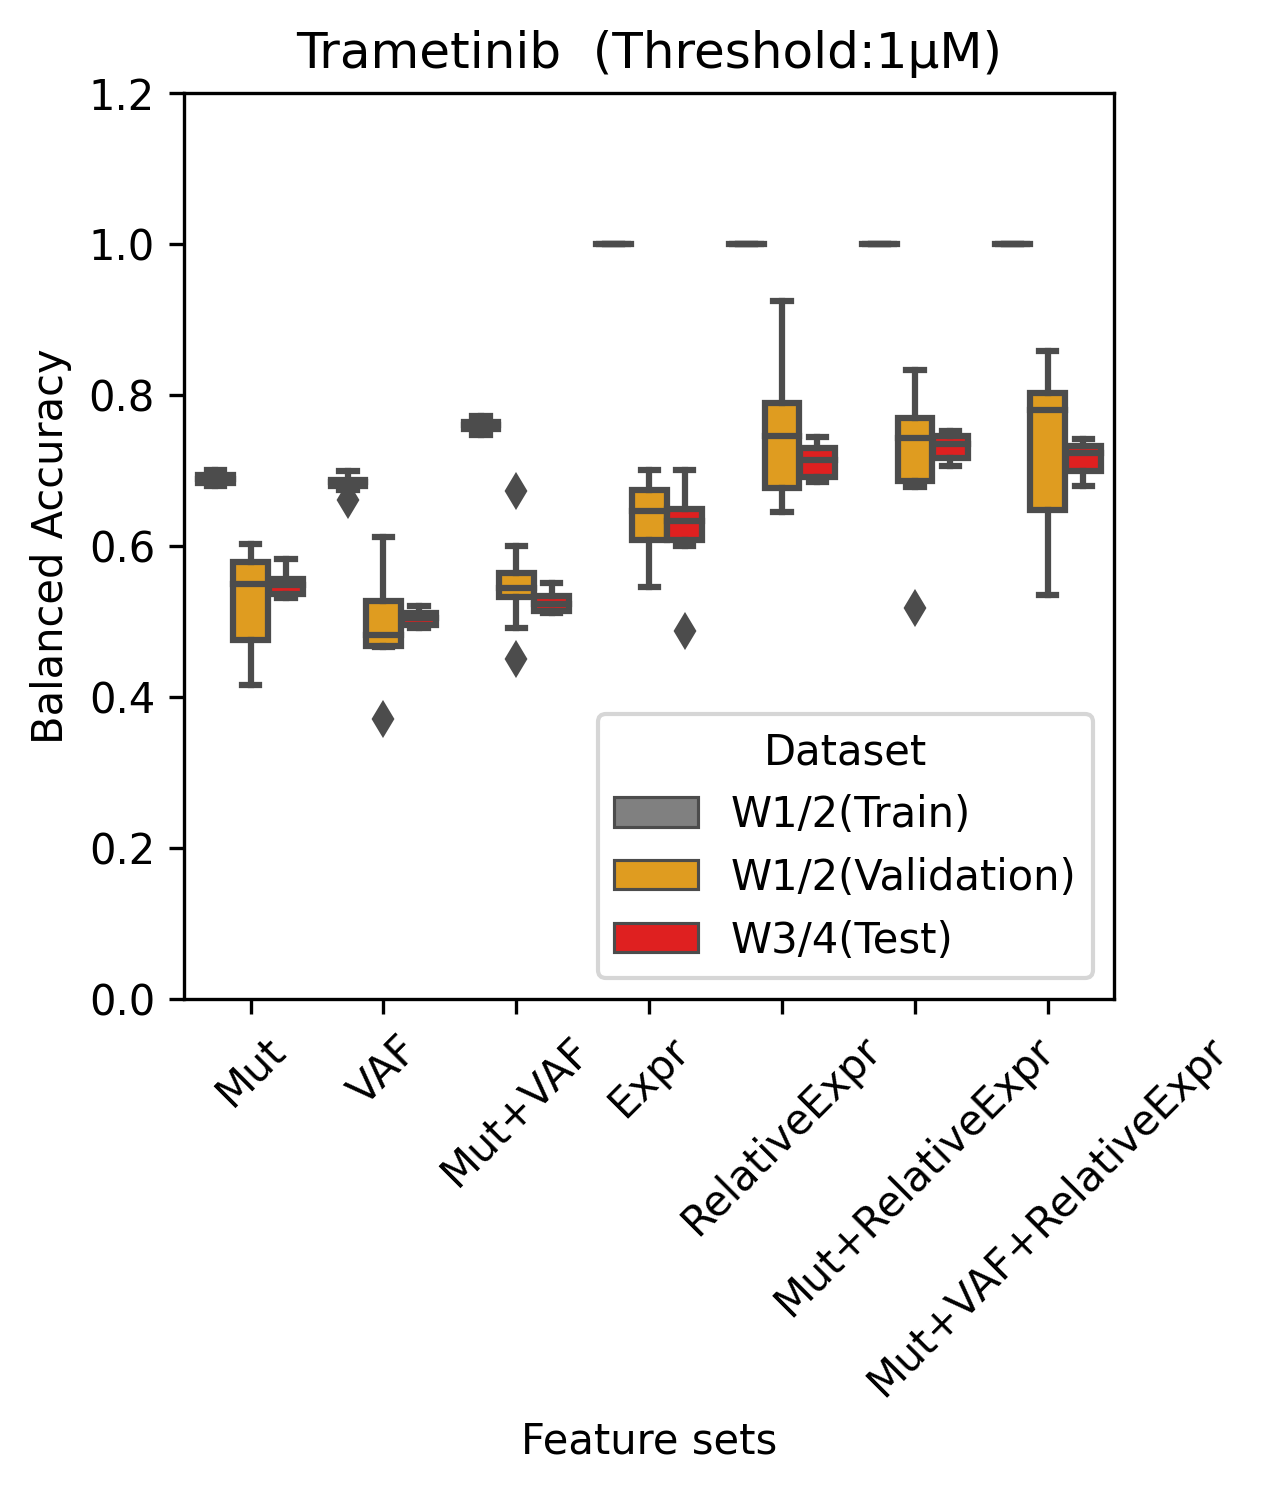

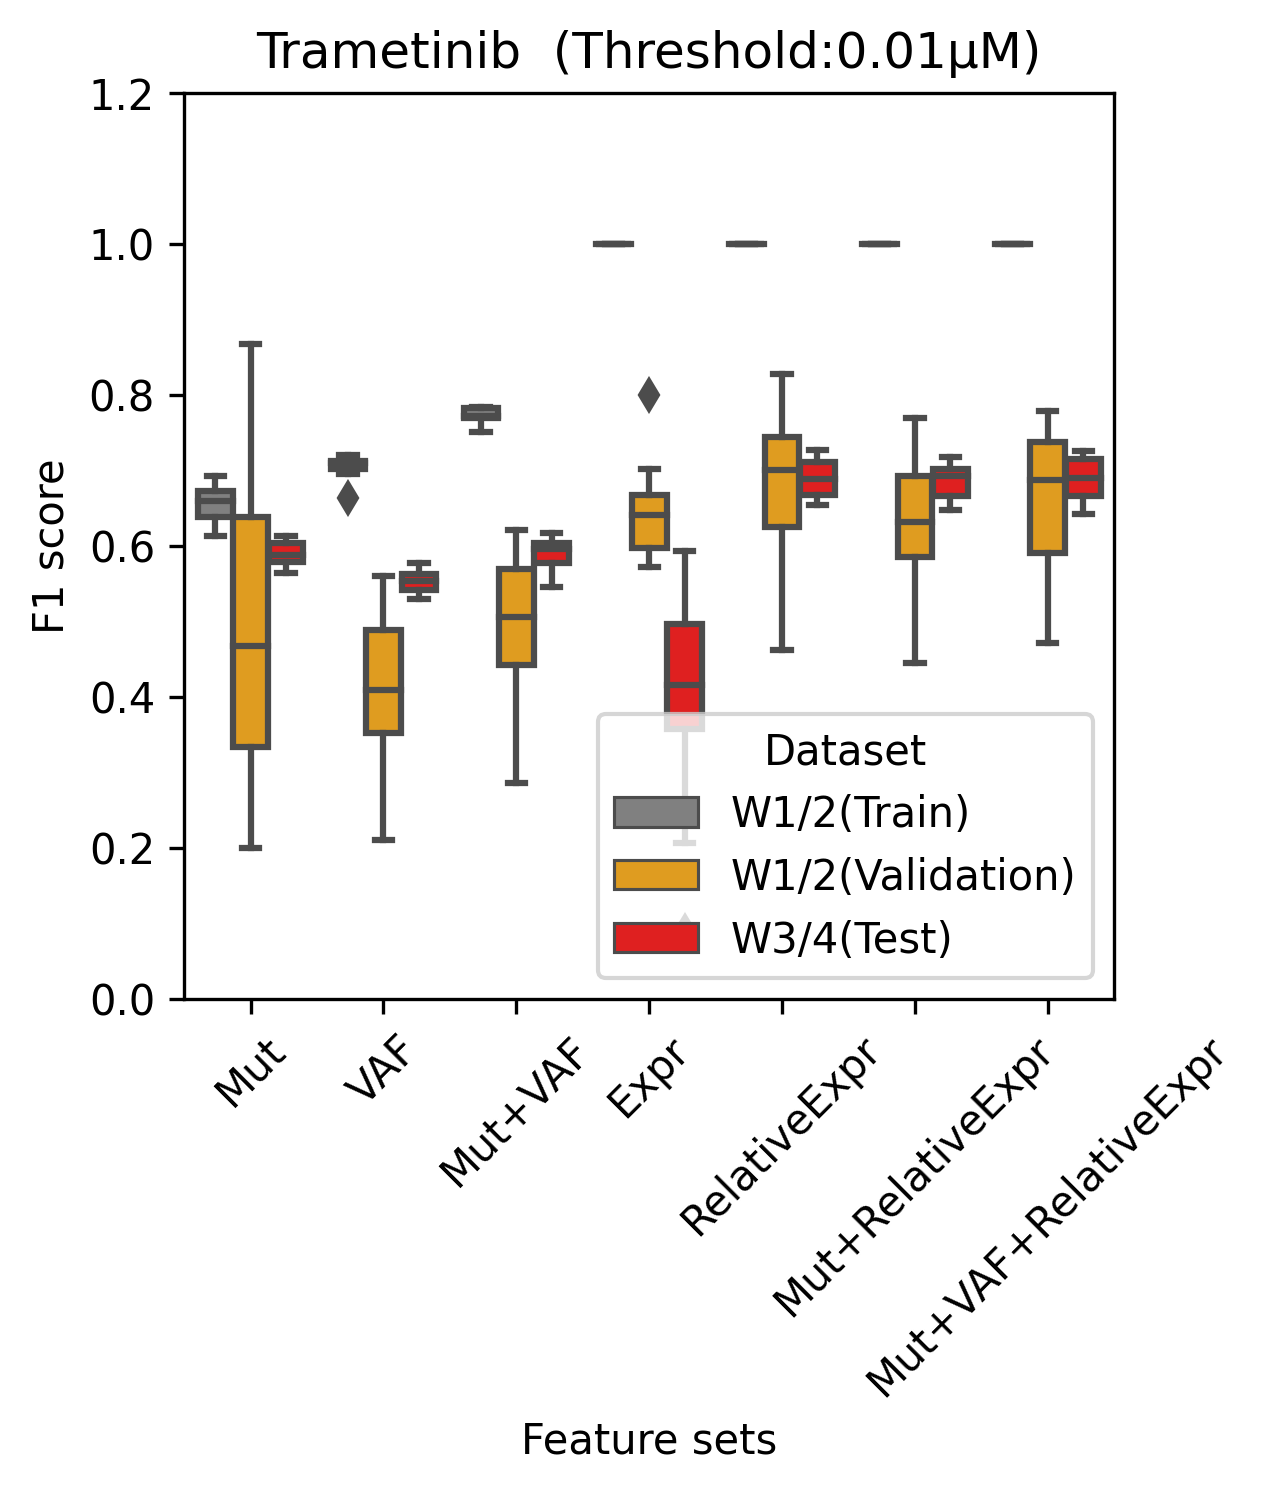

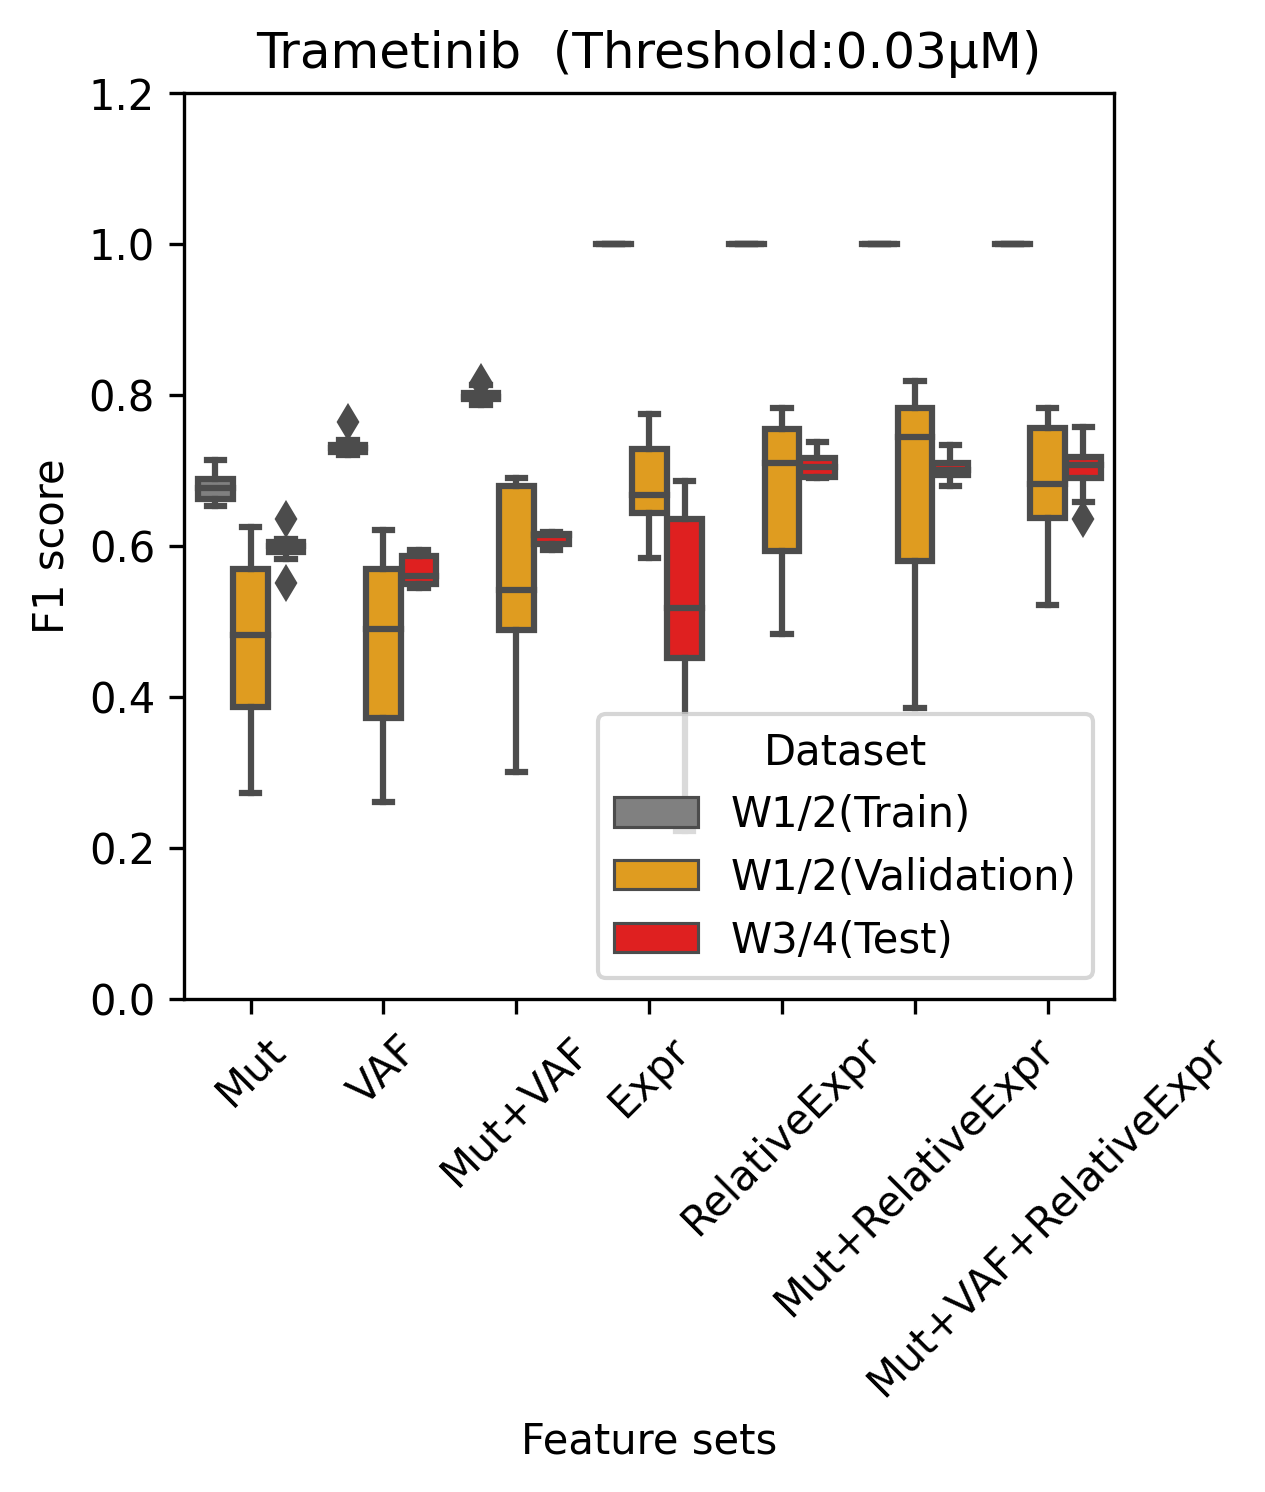

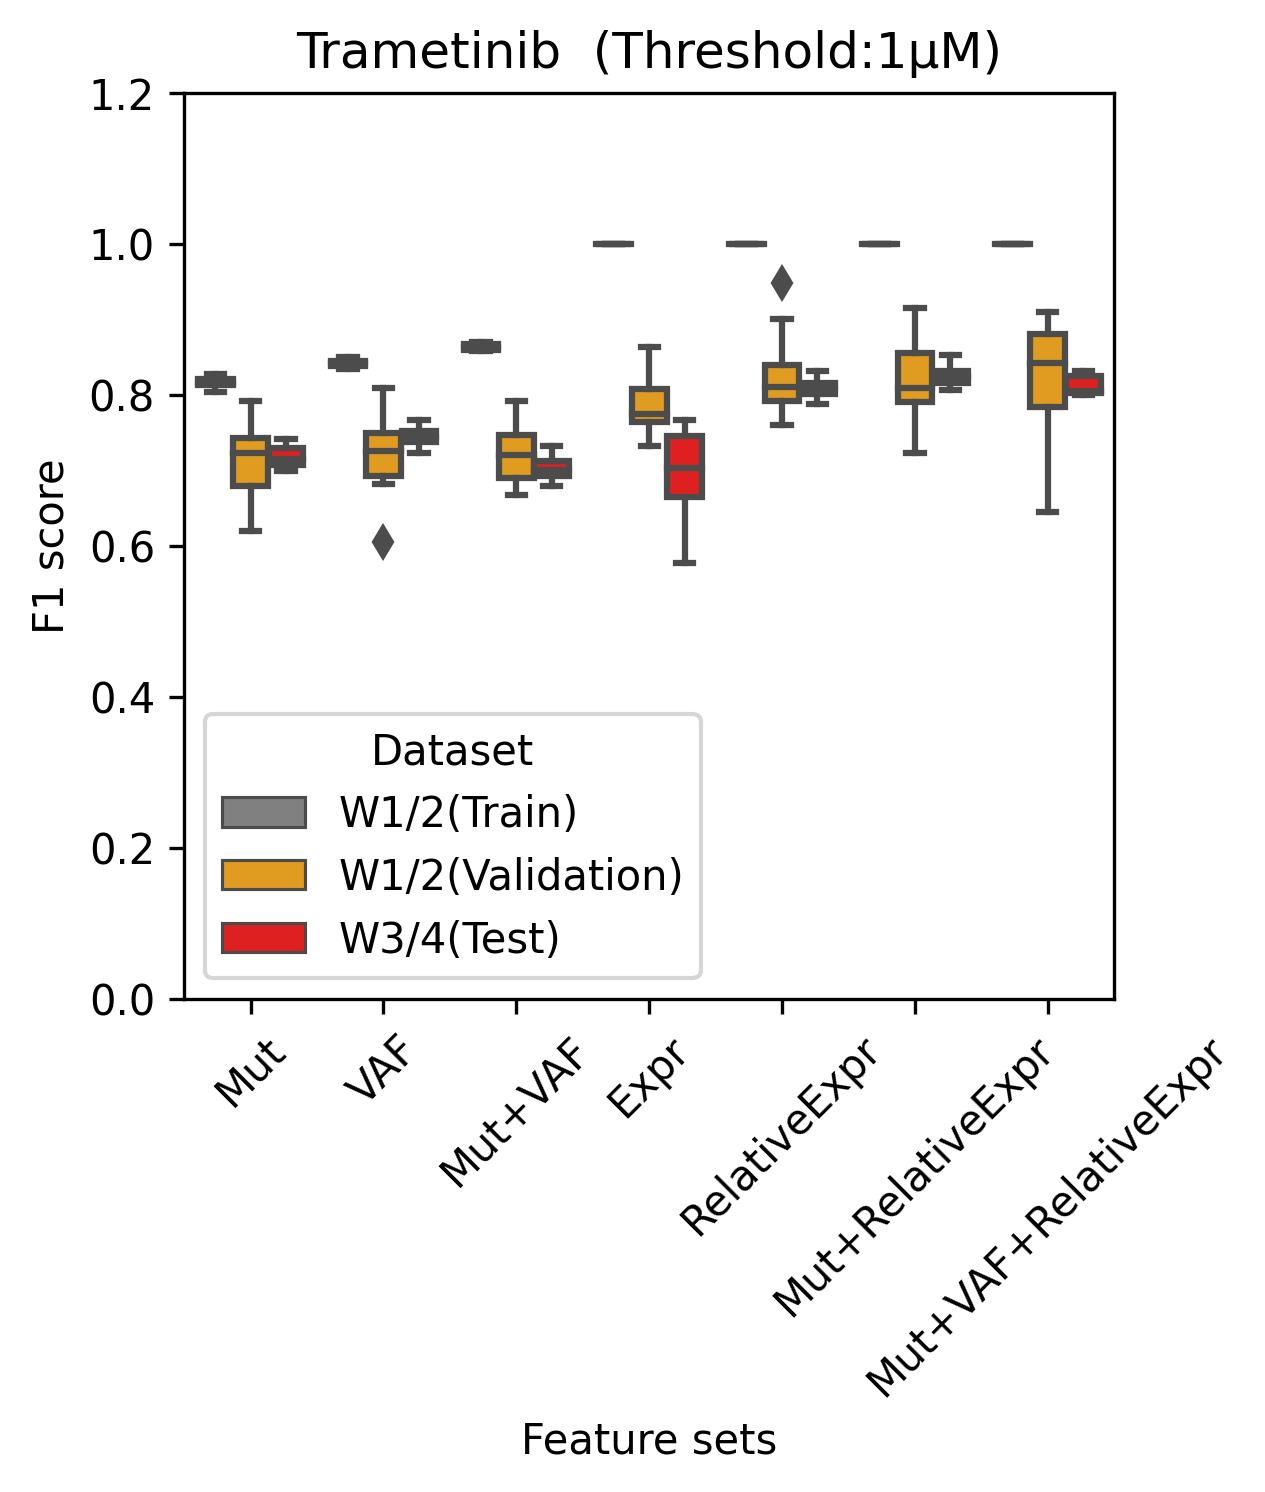

In [91]:
import seaborn as sns
for threshold in threshold_list:
    result_df_cur_threshod = result_df.loc[result_df['Threshold'] ==threshold ]

    #boxplot of result_df_cur_threshold grouped by feature_set
    plt.figure(figsize = (4,4),dpi = 300)
    sns.boxplot(x="Feature_set", y="Balanced_ACC",
                hue="Dataset", palette=["grey","orange" ,"red"],
                data=result_df_cur_threshod)
    
    plt.xticks(rotation = 45)
    plt.ylim(0,1.2)
    plt.title(Drug.split("(")[0] + " (Threshold:" + str(round(threshold,ndigits=2)) + "μM)")
    #threshold_list_label = ["set1","set3","set4","set1&4"]
    #plt.xticks(range(0,len(threshold_list_label)), threshold_list_label, rotation = 90)

    plt.ylabel("Balanced Accuracy")
    plt.xlabel("Feature sets")
    plt.show()


for threshold in threshold_list:
    result_df_cur_threshod = result_df.loc[result_df['Threshold'] ==threshold ]

    #boxplot of result_df_cur_threshold grouped by feature_set
    plt.figure(figsize = (4,4),dpi = 300)
    sns.boxplot(x="Feature_set", y="F1",
                hue="Dataset", palette=["grey","orange","red"],
                data=result_df_cur_threshod)
    plt.xticks(rotation = 45)
    plt.ylim(0,1.2)
    plt.title(Drug.split("(")[0] + " (Threshold:" + str(round(threshold,ndigits=2)) + "μM)")
    #threshold_list_label = ["set1","set3","set4","set1&4"]
    #plt.xticks(range(0,len(threshold_list_label)), threshold_list_label, rotation = 90)
    plt.ylabel("F1 score")
    plt.xlabel("Feature sets")
    plt.show()



In [92]:
result_df.to_csv("../Data/Balanced_ACC_feature_sets_trametinib.csv")

In [93]:
threshold_list

[0.013717, 0.025725557096496952, 1]

In [94]:
set(result_df['Feature_set'])

{'Expr',
 'Mut',
 'Mut+RelativeExpr',
 'Mut+VAF',
 'Mut+VAF+RelativeExpr',
 'RelativeExpr',
 'VAF'}

Mut Mut
Mut VAF
Mut Mut+VAF
Mut Expr
Mut RelativeExpr
Mut Mut+RelativeExpr
Mut Mut+VAF+RelativeExpr
VAF Mut
VAF VAF
VAF Mut+VAF
VAF Expr
VAF RelativeExpr
VAF Mut+RelativeExpr
VAF Mut+VAF+RelativeExpr
Mut+VAF Mut
Mut+VAF VAF
Mut+VAF Mut+VAF
Mut+VAF Expr
Mut+VAF RelativeExpr
Mut+VAF Mut+RelativeExpr
Mut+VAF Mut+VAF+RelativeExpr
Expr Mut
Expr VAF
Expr Mut+VAF
Expr Expr
Expr RelativeExpr
Expr Mut+RelativeExpr
Expr Mut+VAF+RelativeExpr
RelativeExpr Mut
RelativeExpr VAF
RelativeExpr Mut+VAF
RelativeExpr Expr
RelativeExpr RelativeExpr
RelativeExpr Mut+RelativeExpr
RelativeExpr Mut+VAF+RelativeExpr
Mut+RelativeExpr Mut
Mut+RelativeExpr VAF
Mut+RelativeExpr Mut+VAF
Mut+RelativeExpr Expr
Mut+RelativeExpr RelativeExpr
Mut+RelativeExpr Mut+RelativeExpr
Mut+RelativeExpr Mut+VAF+RelativeExpr
Mut+VAF+RelativeExpr Mut
Mut+VAF+RelativeExpr VAF
Mut+VAF+RelativeExpr Mut+VAF
Mut+VAF+RelativeExpr Expr
Mut+VAF+RelativeExpr RelativeExpr
Mut+VAF+RelativeExpr Mut+RelativeExpr
Mut+VAF+RelativeExpr Mut+VAF+Relat

/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal

([<matplotlib.axis.YTick at 0x14a581840>,
 [Text(0, 0.5, 'Mut'),
  Text(0, 1.5, 'VAF'),
  Text(0, 2.5, 'Mut+VAF'),
  Text(0, 3.5, 'Expr'),
  Text(0, 4.5, 'RelativeExpr'),
  Text(0, 5.5, 'Mut+RelativeExpr'),
  Text(0, 6.5, 'Mut+VAF+RelativeExpr')])

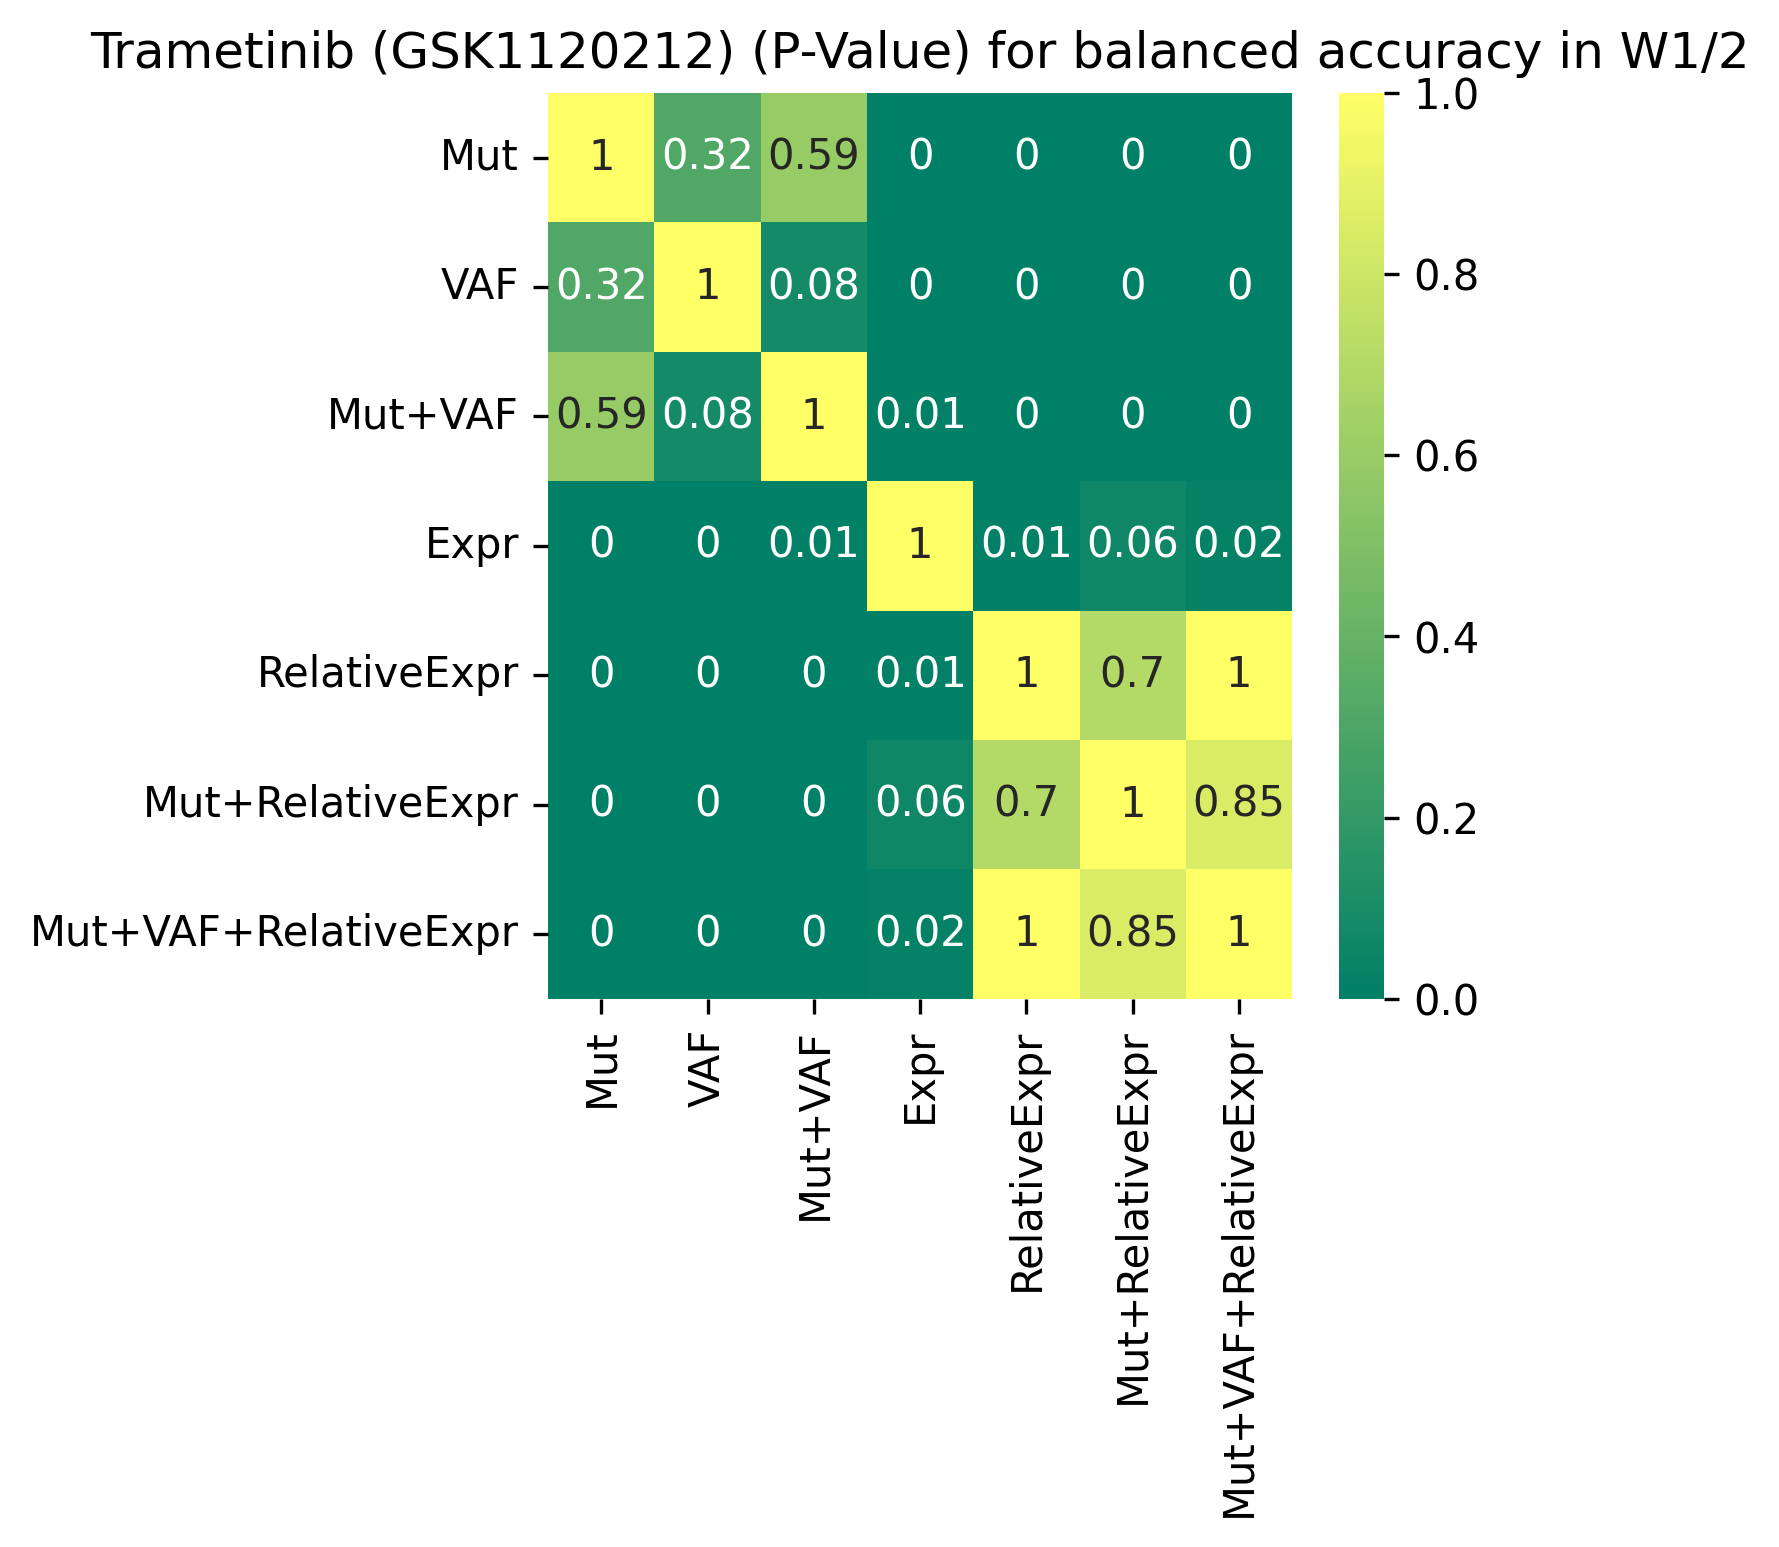

In [98]:

r_data = result_df.loc[result_df['Dataset'] == 'W1/2(Validation)']
r_data = r_data.loc[r_data['Threshold'] == 1	]
# ranksum test
from scipy.stats import ranksums, wilcoxon
featureset = [ 'Mut', 'VAF','Mut+VAF', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr','Mut+VAF+RelativeExpr']

result_p = pd.DataFrame()
row_list = []
for feature1 in featureset:
    p_list_cur = []
    for feature2 in featureset:
        print(feature1, feature2)
        if feature1 != feature2:
            d = r_data.loc[r_data['Feature_set'] == feature1]['Balanced_ACC'].values  - r_data.loc[r_data['Feature_set'] == feature2]['Balanced_ACC'].values
            p = wilcoxon(d)[1]
        else:
            p = 1
        #p = ranksums(r_data.loc[r_data['Feature_set'] == feature1]['Balanced_ACC'].values, 
        #             r_data.loc[r_data['Feature_set'] == feature2]['Balanced_ACC'].values)[1]
        p_list_cur.append(round(p,2))

    result_p[feature1] = p_list_cur


# heatmap plot for p value
plt.figure(figsize = (4,4),dpi = 300)
sns.heatmap(result_p, annot=True, cmap="summer")
plt.title(Drug + " (P-Value) for balanced accuracy in W1/2")
#plt.xticks([0.5,1.5,2.5,3.5,4,5,5.5], featureset, rotation = 90)
plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5], featureset, rotation = 0)
# set fontsize for the legend

In [ ]:
r_data

,Threshold,Feature_set,Balanced_ACC,F1,Dataset
200,1.452619,Mut,0.587678,0.616162,W3/4(Test)
201,1.452619,Mut,0.626291,0.620321,W3/4(Test)
202,1.452619,Mut,0.575566,0.590674,W3/4(Test)
203,1.452619,Mut,0.589769,0.576087,W3/4(Test)
204,1.452619,Mut,0.550111,0.594059,W3/4(Test)
205,1.452619,Mut,0.550295,0.557895,W3/4(Test)
206,1.452619,Mut,0.549250,0.578680,W3/4(Test)
207,1.452619,Mut,0.622664,0.592179,W3/4(Test)
208,1.452619,Mut,0.655558,0.609195,W3/4(Test)
209,1.452619,Mut,0.576611,0.569892,W3/4(Test)


([<matplotlib.axis.YTick at 0x14c73d180>,
 [Text(0, 0.5, 'Mut'),
  Text(0, 1.5, 'VAF'),
  Text(0, 2.5, 'Mut+VAF'),
  Text(0, 3.5, 'Expr'),
  Text(0, 4.5, 'RelativeExpr'),
  Text(0, 5.5, 'Mut+RelativeExpr'),
  Text(0, 6.5, 'Mut+VAF+RelativeExpr')])

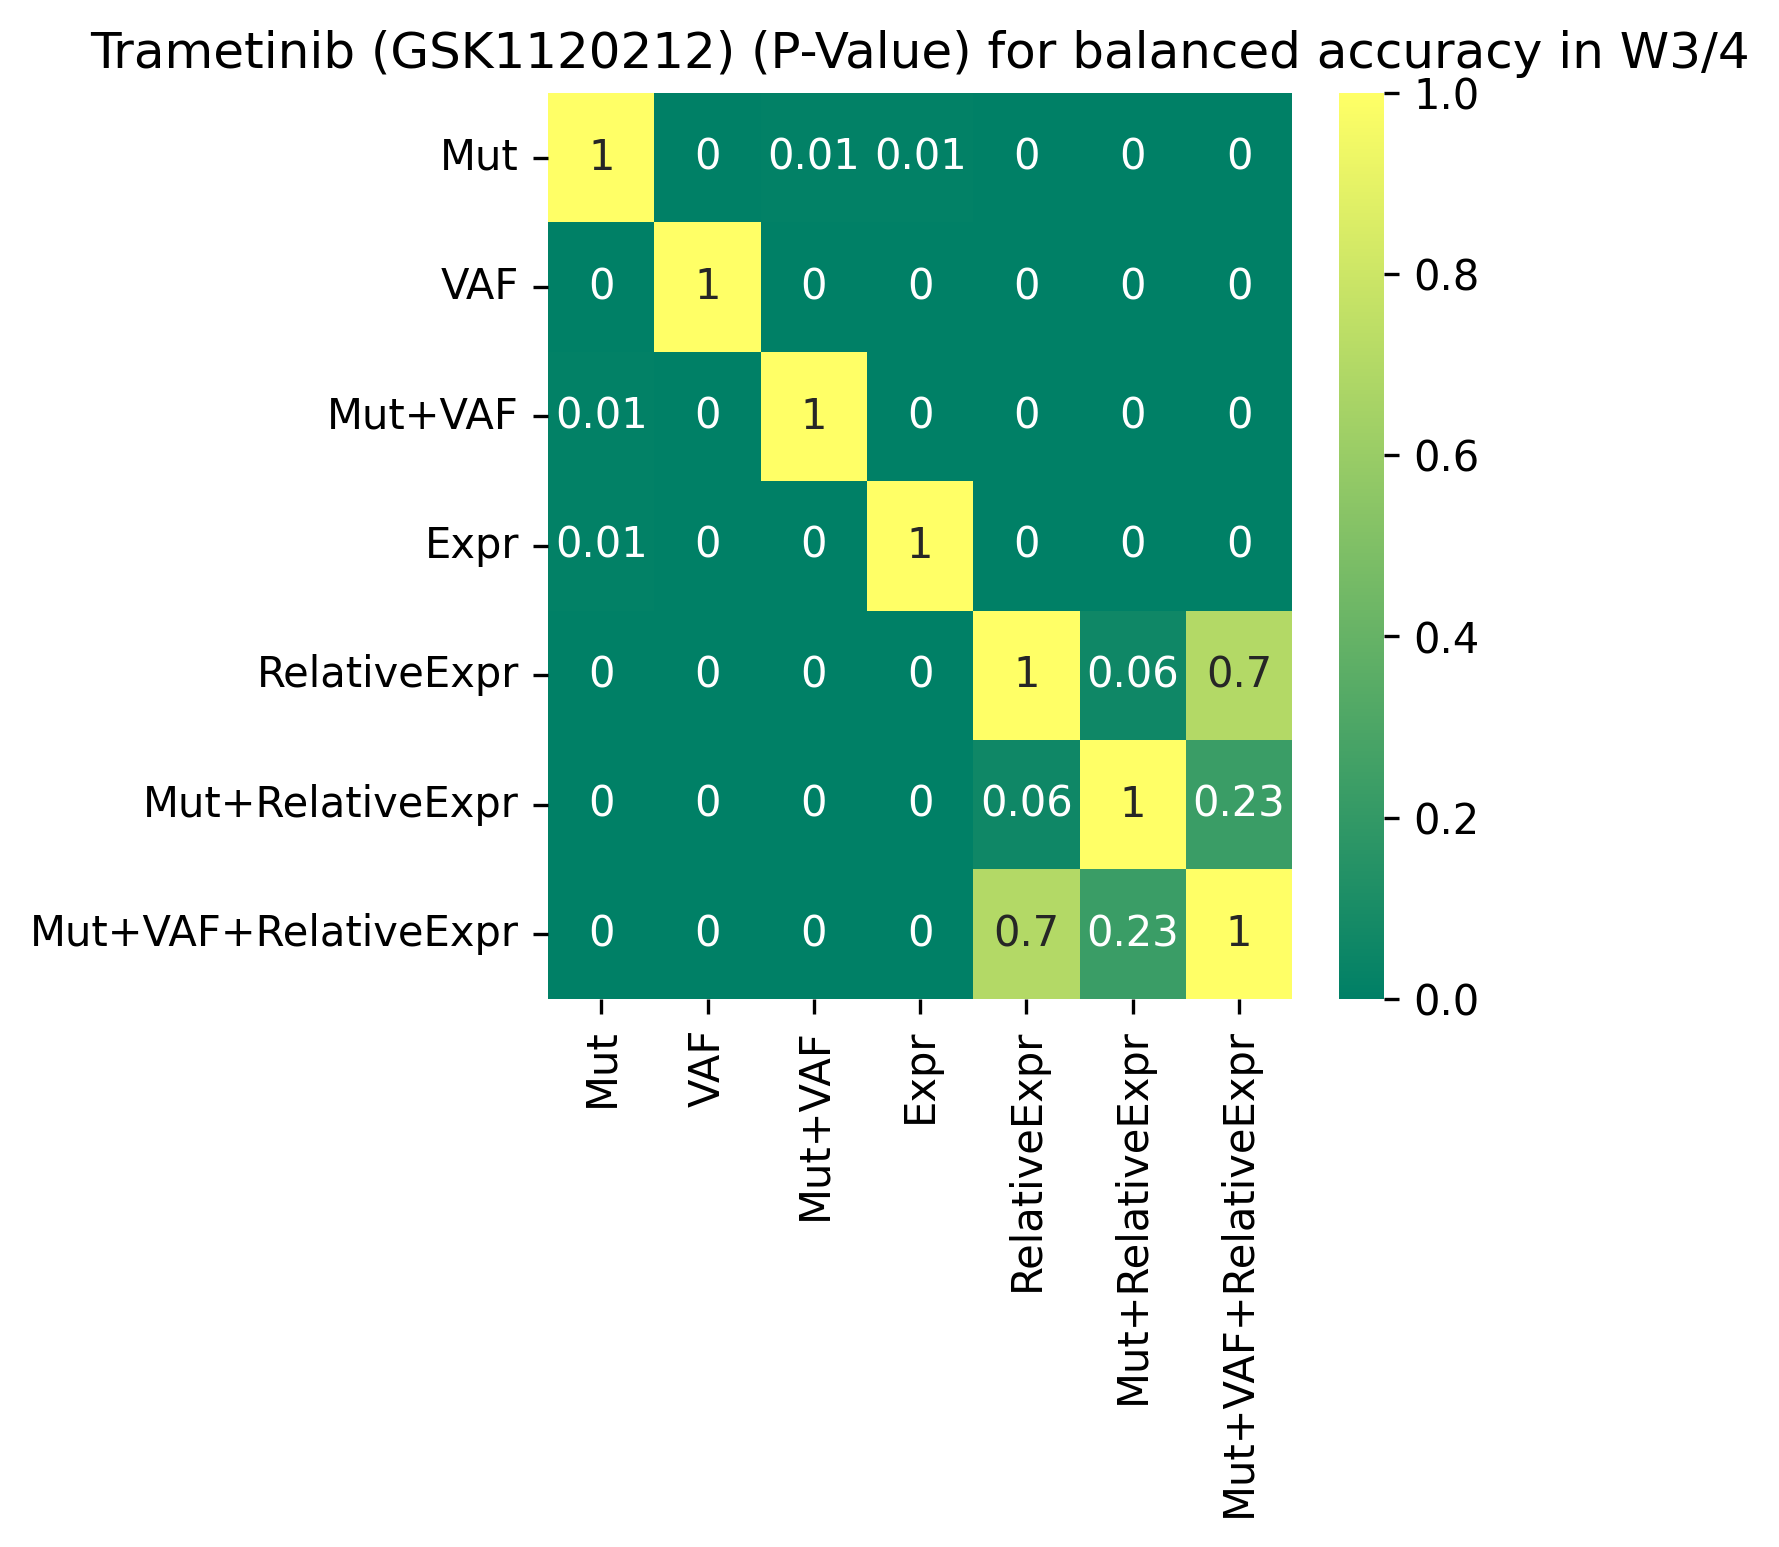

In [101]:
r_data = result_df.loc[result_df['Dataset'] == 'W3/4(Test)']
r_data = r_data.loc[r_data['Threshold'] == 1	]

# ranksum test
from scipy.stats import ranksums,wilcoxon
featureset = [ 'Mut', 'VAF','Mut+VAF', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr','Mut+VAF+RelativeExpr']

result_p = pd.DataFrame()
row_list = []
for feature1 in featureset:
    p_list_cur = []
    for feature2 in featureset:
        if feature1 != feature2:
            d = r_data.loc[r_data['Feature_set'] == feature1]['Balanced_ACC'].values - r_data.loc[r_data['Feature_set'] == feature2]['Balanced_ACC'].values
            p = wilcoxon(d)[1]
        else:
            p = 1

        #print(feature1, feature2)
        #d = r_data.loc[r_data['Feature_set'] == feature1]['Balanced_ACC'].values - r_data.loc[r_data['Feature_set'] == feature2]['Balanced_ACC'].values
        #print(d)
        #p = wilcoxon(d)[1]
        p_list_cur.append(round(p,2))

    result_p[feature1] = p_list_cur


# heatmap plot for p value
plt.figure(figsize = (4,4),dpi = 300)
sns.heatmap(result_p, annot=True, cmap="summer")
plt.title(Drug + " (P-Value) for balanced accuracy in W3/4")
#plt.xticks([0.5,1.5,2.5,3.5,4,5,5.5], featureset, rotation = 90)
plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5], featureset, rotation = 0)
# set fontsize for the legend

([<matplotlib.axis.YTick at 0x1489392a0>,
 [Text(0, 0.5, 'Mut'),
  Text(0, 1.5, 'Expr'),
  Text(0, 2.5, 'RelativeExpr'),
  Text(0, 3.5, 'Mut+RelativeExpr')])

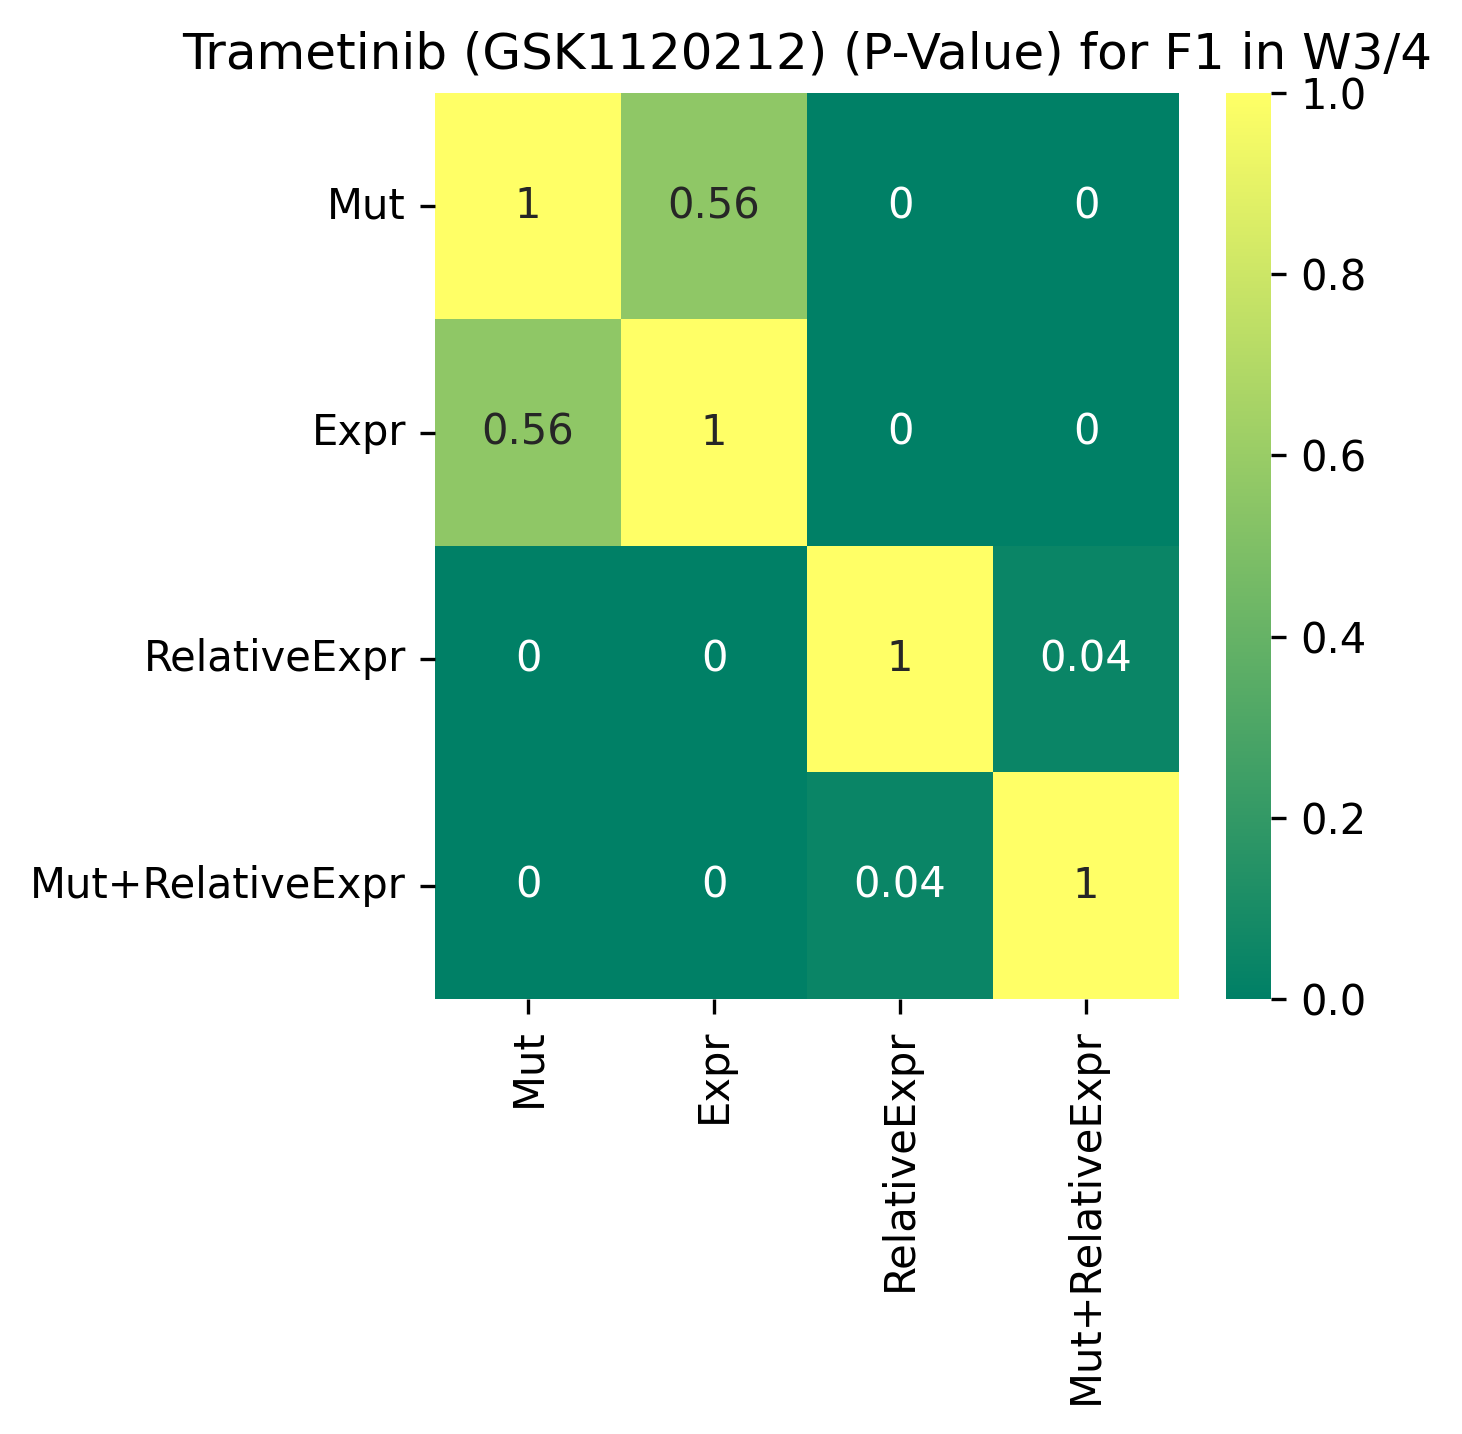

In [102]:
r_data = result_df.loc[result_df['Dataset'] == 'W3/4(Test)']
r_data = r_data.loc[r_data['Threshold'] == 1	]

# ranksum test
from scipy.stats import ranksums,wilcoxon
featureset = [ 'Mut', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr']

result_p = pd.DataFrame()
row_list = []
for feature1 in featureset:
    p_list_cur = []
    for feature2 in featureset:
        if feature1 != feature2:
            d = r_data.loc[r_data['Feature_set'] == feature1]['F1'].values - r_data.loc[r_data['Feature_set'] == feature2]['F1'].values
            p = wilcoxon(d)[1]
        else:
            p = 1

        #print(feature1, feature2)
        #d = r_data.loc[r_data['Feature_set'] == feature1]['Balanced_ACC'].values - r_data.loc[r_data['Feature_set'] == feature2]['Balanced_ACC'].values
        #print(d)
        #p = wilcoxon(d)[1]
        p_list_cur.append(round(p,2))

    result_p[feature1] = p_list_cur


# heatmap plot for p value
plt.figure(figsize = (4,4),dpi = 300)
sns.heatmap(result_p, annot=True, cmap="summer")
plt.title(Drug + " (P-Value) for F1 in W3/4")
#plt.xticks([0.5,1.5,2.5,3.5,4,5,5.5], featureset, rotation = 90)
plt.yticks([0.5,1.5,2.5,3.5], featureset, rotation = 0)
# set fontsize for the legend

In [ ]:
len(cur_df.loc[cur_df['Dataset'] == 'W1/2(Validation)']['Balanced_ACC'].values)

10

In [ ]:
r_data = result_df.loc[result_df['Threshold'] == 1.45261900330956]

# compare groups between w1/2 and w3/4 
# ranksum test
from scipy.stats import ranksums, wilcoxon
featureset = [ 'Mut', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr']

result_p = pd.DataFrame()
row_list = []

p_list_cur = []
for feature1 in featureset:
    print(feature1)
    cur_df = r_data.loc[r_data['Feature_set'] == feature1]
    d = cur_df.loc[cur_df['Dataset'] == 'W3/4(Test)']['Balanced_ACC'].values - cur_df.loc[cur_df['Dataset'] == 'W1/2(Validation)']['Balanced_ACC'].values
    p = ranksums(cur_df.loc[cur_df['Dataset'] == 'W3/4(Test)']['Balanced_ACC'].values, 
                 cur_df.loc[cur_df['Dataset'] == 'W1/2(Validation)']['Balanced_ACC'].values)[1]
    print("ranksums")
    print(p)
    print("wilcoxon")
    p = wilcoxon(d)[1]
    print(p)
    p_list_cur.append(p)

print("P values between W1/2 and W3/4")
print(p_list_cur)

Mut
ranksums
0.034293721036492766
wilcoxon
0.064453125
Expr
ranksums
0.034293721036492766
wilcoxon
0.10546875
RelativeExpr
ranksums
0.6501474440948545
wilcoxon
0.6953125
Mut+RelativeExpr
ranksums
0.5967012167293563
wilcoxon
0.76953125
P values between W1/2 and W3/4
[0.064453125, 0.10546875, 0.6953125, 0.76953125]


In [ ]:
r_data = result_df.loc[result_df['Threshold'] == 1.45261900330956]

# compare groups between w1/2 and w3/4 
# ranksum test
from scipy.stats import ranksums, wilcoxon
featureset = [ 'Mut', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr']

result_p = pd.DataFrame()
row_list = []

p_list_cur = []
for feature1 in featureset:
    print(feature1)
    
    cur_df = r_data.loc[r_data['Feature_set'] == feature1]
    d = cur_df.loc[cur_df['Dataset'] == 'W3/4(Test)']['F1'].values - cur_df.loc[cur_df['Dataset'] == 'W1/2(Validation)']['F1'].values
    p = wilcoxon(d)[1]
    print(p)
    p_list_cur.append(p)

print("P values between W1/2 and W3/4")
print(p_list_cur)

Mut
0.037109375
Expr
0.193359375
RelativeExpr
0.4921875
Mut+RelativeExpr
0.232421875
P values between W1/2 and W3/4
[0.037109375, 0.193359375, 0.4921875, 0.232421875]


In [ ]:
result_with_threshod.keys()

dict_keys([0.0190925713799281, 1.45261900330956])

(290, 10)


Text(0, 0.5, 'Feature importance (RelativeExpr)')

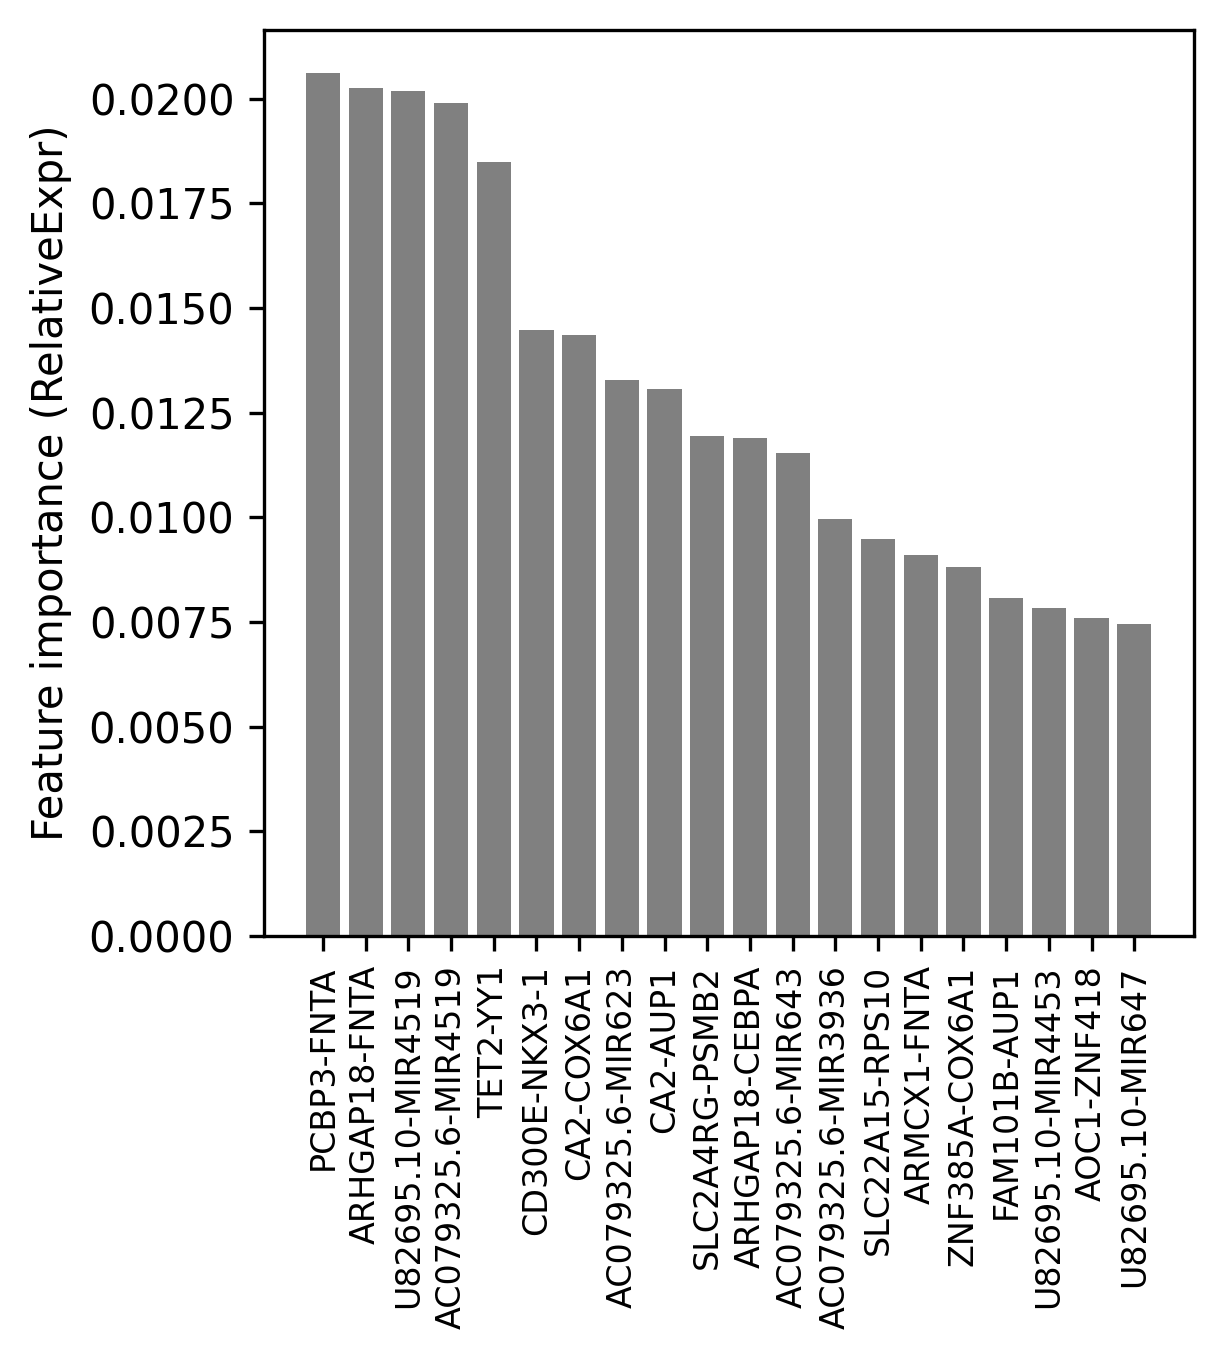

In [107]:

feature_IMP =pd.DataFrame()
Threshold = 1
featureset_cur = "RelativeExpr"
#featureset_cur = "Expr"
#featureset_cur = "Mut+RelativeExpr"
#featureset_cur = "Mut"

for random_state in result_with_threshod[Threshold][featureset_cur]:
    if result_with_threshod[Threshold][featureset_cur][random_state]['balanced_acc'] > 0.6:
        features = result_with_threshod[Threshold][featureset_cur][random_state]['features']['Feature'].values
        IMP = result_with_threshod[Threshold][featureset_cur][random_state]['features']['IMP'].values
        cur_df = pd.DataFrame({"IMP" + str(random_state): IMP})
        cur_df.index = features
        feature_IMP = pd.concat([feature_IMP,cur_df ],axis =1)
print(feature_IMP.shape)
IMP_sum = feature_IMP.transpose().sum()/feature_IMP.transpose().shape[0]
x_feature = pd.DataFrame({"Feature":IMP_sum.index, "IMP":IMP_sum.values})
x_feature_sorted = x_feature.sort_values(by = ["IMP"], ascending = False).head(20)

plt.figure(figsize = (4,4),dpi = 300)
plt.bar(np.arange(0,x_feature_sorted.shape[0], 1), x_feature_sorted['IMP'], width=0.8,  color = 'grey',
        bottom=None,  align='center')
#plt.ylabel("correlation coeffient")

xticks_new = []
for i in x_feature_sorted['Feature']:
    
    if i.startswith("ENSG") and i in dic_gene_map:
        xticks_new.append(dic_gene_map[i])
    else: 
        xticks_new.append(i)


plt.xticks(np.arange(0,x_feature_sorted.shape[0], 1),xticks_new , rotation = 90, fontsize =8)
plt.ylabel("Feature importance (" + featureset_cur + ")")


